# Train a model to generate structure of a piece (MELONS-inspired)

1. Read structure dataset from POP909_structure
2. Pre-process str into graph format
3. Setup transformer model
4. Train-val split, data loader
5. Evaluate model predictions

In [1]:
import torch
import os
import re

In [2]:
structure_path = "POP909_structure"

In [3]:
labels = []
label_paths = ["human_label1", "human_label2"]
for folder in os.listdir(structure_path):
    for label_path in label_paths:
        try:
            f = open(f"{structure_path}/{folder}/{label_path}.txt", "r")
            # print(f.read())
            labels.append(f.read())
        except:
            continue

In [4]:
labels[:5]

['i8A8A8B8C4C4b4b4x2A8B8C4C4C4C4X1o1\n',
 'i8A7A8B8C4C5b5b5A8B8C4C4C4C5o1\n',
 'i4A4A4B4B4C4C4C4D4x4B4B4C4C4C4D4X3\n',
 'i4A4A4B4B4C8C8x4B4B4C8C8X4\n',
 'i4A8A8B4C4b5x1b5A8B4x1C4C4\n']

In [5]:
def split_string(s):
    # This regex pattern matches a letter followed by one or more digits
    pattern = re.compile(r'[a-zA-Z]\d+')
    # Find all matches in the string
    matches = pattern.findall(s)
    return matches

In [6]:
split_string(labels[3])

['i4', 'A4', 'A4', 'B4', 'B4', 'C8', 'C8', 'x4', 'B4', 'B4', 'C8', 'C8', 'X4']

In [7]:
all_phrases = []
for label in labels:
    all_phrases.append(split_string(label))

In [8]:
all_phrases[:3]

[['i8',
  'A8',
  'A8',
  'B8',
  'C4',
  'C4',
  'b4',
  'b4',
  'x2',
  'A8',
  'B8',
  'C4',
  'C4',
  'C4',
  'C4',
  'X1',
  'o1'],
 ['i8',
  'A7',
  'A8',
  'B8',
  'C4',
  'C5',
  'b5',
  'b5',
  'A8',
  'B8',
  'C4',
  'C4',
  'C4',
  'C5',
  'o1'],
 ['i4',
  'A4',
  'A4',
  'B4',
  'B4',
  'C4',
  'C4',
  'C4',
  'D4',
  'x4',
  'B4',
  'B4',
  'C4',
  'C4',
  'C4',
  'D4',
  'X3']]

In [9]:
def get_phrase_edge_type(prev_phrase, curr_phrase, prev_phrase_idx, curr_phrase_idx):
    """
    Edge types:
    1: Intro to Any
    2: Any to Outro
    3: Repeated phrase
    4: Melody to Melody
    5: Melody to Non-Melody
    6: Non-Melody to Melody
    7: Non-Melody to Non-Melody
    """
    # print(prev_phrase_idx, curr_phrase_idx)
    
    prev_phrase_type = prev_phrase[0]
    curr_phrase_type = curr_phrase[0]
    
    if prev_phrase == curr_phrase:
            return 3
    
    if prev_phrase_idx + 1 == curr_phrase_idx:
        # print(prev_phrase_type)
    
        if prev_phrase_type == "i":
            return 1
        elif curr_phrase_type == "o":
            return 2
        elif prev_phrase_type.isupper() & curr_phrase_type.isupper():
            return 4
        elif prev_phrase_type.isupper() & curr_phrase_type.islower():
            return 5
        elif prev_phrase_type.islower() & curr_phrase_type.isupper():
            return 6
        elif prev_phrase_type.islower() & curr_phrase_type.islower():
            return 7
        else:
            return None

In [10]:
get_phrase_edge_type("A4", "B4", 1, 2)

4

In [11]:
all_phrases[0]

['i8',
 'A8',
 'A8',
 'B8',
 'C4',
 'C4',
 'b4',
 'b4',
 'x2',
 'A8',
 'B8',
 'C4',
 'C4',
 'C4',
 'C4',
 'X1',
 'o1']

In [12]:
# TODO: Get max size of phrases

In [13]:
def create_sequence(phrases):
    # Create sequence of edges from phrase, where each item is a tuple (i, j, edge type, num bars in i, num bars in j)
    # Start seq with START token
    seq = [(40, 40, 8, 10, 10)]
    max_phrase_len = 0
    for i, phrase_from in enumerate(phrases):
        for j, phrase_to in enumerate(phrases[i+1:]):
            phrase_to_idx = j+i+1
            edge_type = get_phrase_edge_type(phrase_from, phrase_to, i, phrase_to_idx)
            if edge_type is not None:
                phrase_from_len = int(phrase_from[1])
                phrase_to_len = int(phrase_to[1])
                max_phrase_len = max(max_phrase_len, max(phrase_from_len, phrase_to_len))
                seq.append((i+1, phrase_to_idx+1, edge_type, phrase_from_len, phrase_to_len))
    
    # Append END token
    seq.append((41, 41, 9, 11, 11))
    return seq, max_phrase_len

In [14]:
seqs = []
max_phrase_len = 0
max_num_nodes = 0
for phrases in all_phrases:
    # print(phrases)
    num_nodes = len(phrases)
    seq, max_phrase_len_indiv = create_sequence(phrases)
    seqs.append(seq)
    max_phrase_len = max(max_phrase_len, max_phrase_len_indiv)
    max_num_nodes = max(max_num_nodes, num_nodes)

In [15]:
all_phrases[1]

['i8',
 'A7',
 'A8',
 'B8',
 'C4',
 'C5',
 'b5',
 'b5',
 'A8',
 'B8',
 'C4',
 'C4',
 'C4',
 'C5',
 'o1']

In [16]:
seqs[1]

[(40, 40, 8, 10, 10),
 (1, 2, 1, 8, 7),
 (2, 3, 4, 7, 8),
 (3, 4, 4, 8, 8),
 (3, 9, 3, 8, 8),
 (4, 5, 4, 8, 4),
 (4, 10, 3, 8, 8),
 (5, 6, 4, 4, 5),
 (5, 11, 3, 4, 4),
 (5, 12, 3, 4, 4),
 (5, 13, 3, 4, 4),
 (6, 7, 5, 5, 5),
 (6, 14, 3, 5, 5),
 (7, 8, 3, 5, 5),
 (8, 9, 6, 5, 8),
 (9, 10, 4, 8, 8),
 (10, 11, 4, 8, 4),
 (11, 12, 3, 4, 4),
 (11, 13, 3, 4, 4),
 (12, 13, 3, 4, 4),
 (13, 14, 4, 4, 5),
 (14, 15, 2, 5, 1),
 (41, 41, 9, 11, 11)]

In [17]:
max_phrase_len

9

In [18]:
max_num_nodes

39

In [19]:
len(seqs[2])

34

## Dataloader

In [20]:
import torch
from torch.nn.utils.rnn import pad_sequence

def sequences_to_tensor(sequences, padding_value=0):
    """
    Convert a list of sequences of different lengths to a padded tensor.

    Args:
        sequences (list of list of tuples): List of sequences where each sequence is a list of tuples.
        padding_value (int, optional): Value to use for padding. Defaults to 0.

    Returns:
        torch.Tensor: Padded tensor of shape (batch_size, max_length, tuple_length)
    """
    # Convert each sequence to a tensor
    tensor_sequences = [torch.tensor(seq) for seq in sequences]

    # Pad sequences to the length of the longest sequence
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=padding_value)

    return padded_sequences


In [21]:
len(seqs)

1818

In [22]:
padded_seq = sequences_to_tensor(seqs, padding_value=0)
print("Padded seq shape:", padded_seq.shape)

Padded seq shape: torch.Size([1818, 152, 5])


In [23]:
from torch.utils.data import Dataset, DataLoader, random_split

In [24]:
# Train-test split
test_ratio = 0.1

num_test = round(len(seqs) * test_ratio)
train_split, test_split = random_split(padded_seq, [len(seqs)-num_test, num_test])
print(f"Split data into Train and Test sets of size {len(train_split)} and {len(test_split)} respectively.")

Split data into Train and Test sets of size 1636 and 182 respectively.


In [25]:
# Define the custom dataset
class TupleSequenceDataset(Dataset):
    def __init__(self, input_sequences, output_sequences):
        self.input_sequences = input_sequences
        self.output_sequences = output_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return [self.input_sequences[idx], self.output_sequences[idx]]

# Parameters
batch_size = 32
shuffle = True

# Create the dataset
dataset_train = TupleSequenceDataset(train_split, train_split)
dataset_test = TupleSequenceDataset(test_split, test_split)

# Create the DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=shuffle)


In [26]:
n_token = [max_num_nodes+4, max_num_nodes+4, 10, max_phrase_len+3, max_phrase_len+3]
# +1 to all to account for indices
# +1 to max_num_nodes to account for START/END/PAD tokens
# n_token[2] = 7+3 to account for START/END/PAD tokens

In [27]:
n_token

[43, 43, 10, 12, 12]

## Autoregression transformer

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
from tqdm import tqdm

In [29]:
# Ref: https://github.com/YatingMusic/compound-word-transformer/blob/main/workspace/uncond/cp-linear/main-cp.py
# https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
# https://gist.github.com/danimelchor/bcad4d7f79b98464c4d4481d62d27622

class Embeddings(nn.Module):
    """
    Get embeddings for edge tokens
    """
    def __init__(self, n_token, d_model):
        super(Embeddings, self).__init__()
        # print(n_token)
        self.lut = nn.Embedding(n_token, d_model, padding_idx=0)
        self.d_model = d_model

    def forward(self, x):
        # print(n_token)
        # print(x.shape)
        # print(torch.max(x))
        # print(torch.min(x))
        # print(self.d_model)
        # print(self.lut(x))
        return self.lut(x) * math.sqrt(self.d_model)
    
    
class PositionalEncoding(nn.Module):
    """
    Get positional encodings
    """
    def __init__(self, d_model, dropout=0.1, max_len=20000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
        


class AutoregressiveTransformer(nn.Module):
    def __init__(self, n_token):
        super(AutoregressiveTransformer, self).__init__()
        
        # --- params config --- #
        self.n_token = n_token   
        self.d_model = D_MODEL 
        self.d_feedforward = D_FEEDFW
        self.n_layer = N_LAYER
        self.dropout = 0.1
        self.n_head = N_HEAD
        self.d_head = D_MODEL // N_HEAD
        self.d_inner = 1024
        # self.loss_func = nn.CrossEntropyLoss(reduction='none')
        self.emb_sizes = [128, 128, 12, 16, 16]
        
        
        # --- modules config --- #
        # embeddings
        print('>>>>>:', self.n_token)
        self.emb_i = Embeddings(self.n_token[0], self.emb_sizes[0])
        self.emb_j = Embeddings(self.n_token[1], self.emb_sizes[1])
        self.emb_edge_type = Embeddings(self.n_token[2], self.emb_sizes[2])
        self.emb_i_size = Embeddings(self.n_token[3], self.emb_sizes[3])
        self.emb_j_size = Embeddings(self.n_token[4], self.emb_sizes[4])
        self.pos_emb = PositionalEncoding(self.d_model, self.dropout)

        # linear 
        self.in_linear = nn.Linear(np.sum(self.emb_sizes), self.d_model)
        
        # encoder
        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.n_head,
            num_encoder_layers=self.n_layer,
            num_decoder_layers=self.n_layer,
            dim_feedforward=self.d_feedforward,
            dropout=self.dropout,
        )

        # individual output
        self.proj_i    = nn.Linear(self.d_model, self.n_token[0])        
        self.proj_j    = nn.Linear(self.d_model, self.n_token[1])
        self.proj_edge_type  = nn.Linear(self.d_model, self.n_token[2])
        self.proj_i_size     = nn.Linear(self.d_model, self.n_token[3])
        self.proj_j_size    = nn.Linear(self.d_model, self.n_token[4])
    
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        '''
        linear transformer: b x s x f
        x.shape=(bs, nf)
        '''
        
        # print(f"src shape: {src.shape}, target shape: {tgt.shape}")
    
        # src embeddings
        emb_i_src =    self.emb_i(src[..., 0])
        emb_j_src =    self.emb_j(src[..., 1])
        emb_edge_type_src =  self.emb_edge_type(src[..., 2])
        emb_i_size_src =     self.emb_i_size(src[..., 3])
        emb_j_size_src =    self.emb_j_size(src[..., 4])

        embs_src = torch.cat(
            [
                emb_i_src,
                emb_j_src,
                emb_edge_type_src,
                emb_i_size_src,
                emb_j_size_src,
            ], dim=-1)

        emb_linear_src = self.in_linear(embs_src)
        pos_emb_src = self.pos_emb(emb_linear_src)
        
        
        # tgt embeddings
        emb_i_tgt =    self.emb_i(tgt[..., 0])
        emb_j_tgt =    self.emb_j(tgt[..., 1])
        emb_edge_type_tgt =  self.emb_edge_type(tgt[..., 2])
        emb_i_size_tgt =     self.emb_i_size(tgt[..., 3])
        emb_j_size_tgt =    self.emb_j_size(tgt[..., 4])

        embs_tgt = torch.cat(
            [
                emb_i_tgt,
                emb_j_tgt,
                emb_edge_type_tgt,
                emb_i_size_tgt,
                emb_j_size_tgt,
            ], dim=-1)

        emb_linear_tgt = self.in_linear(embs_tgt)
        pos_emb_tgt = self.pos_emb(emb_linear_tgt)
        
        # target embeddings
    
        # transformer
        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        # print(pos_emb_src.shape)
        # print(pos_emb_tgt.shape)
        pos_emb_src = pos_emb_src.permute(1,0,2)
        pos_emb_tgt = pos_emb_tgt.permute(1,0,2)
        # print(f"Transformer input dim: {pos_emb_src.shape}, target dim: {pos_emb_tgt.shape}")
        transformer_out = self.transformer(pos_emb_src, pos_emb_tgt, 
                                           tgt_mask=tgt_mask, 
                                           src_key_padding_mask=src_pad_mask, 
                                           tgt_key_padding_mask=tgt_pad_mask)
        # print(f"Transformer output dim: {transformer_out.shape}")
        

        y_i    = self.proj_i(transformer_out)
        y_j    = self.proj_j(transformer_out)
        y_edge_type  = self.proj_edge_type(transformer_out)
        y_i_size    = self.proj_i_size(transformer_out)
        y_j_size = self.proj_j_size(transformer_out)

        return  y_i, y_j, y_edge_type, y_i_size, y_j_size
    
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a square matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)
        



In [30]:
def compute_loss(predict, target, loss_func, padding_token):
        # predict = predict.permute(1, 2, 0)  
        predict = predict.permute(2, 1, 0)  
        # print(torch.min(target))
        # print(torch.max(target))
        # print(f"Predict shape: {predict.shape}, Target shape: {target.shape}")
        loss_mask = (target != 0).float()
        # print(f"Initial loss_mask shape: {loss_mask.shape}")
        loss = loss_func(predict, target)
        # print(f"Initial loss shape: {loss.shape}")
        # print(f"Initial loss: {loss.sum()}")
        loss = loss * loss_mask
        # print(f"Masked loss: {loss.sum()}")
        loss = torch.sum(loss) / torch.sum(loss_mask)
        return loss

In [31]:
def train_loop(model, opt, loss_fn, dataloader):
    
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in dataloader:
        X = batch_X.to(device)
        y = batch_y.to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        # print(f"X shape: {X.shape}")
        # print(f"y_input shape: {y_input.shape}")

        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        # print(f"mask shape: {tgt_mask.shape}")        
        
        y_i, y_j, y_edge_type, y_i_size, y_j_size = model(X, y_input, tgt_mask)
        
        # print(f"shape after model pred: {y_i.shape}, {y_j.shape}")

        # reshape (b, s, f) -> (b, f, s)
        y_i = y_i[:, ...].permute(0, 2, 1)
        y_j = y_j[:, ...].permute(0, 2, 1)
        y_edge_type = y_edge_type[:, ...].permute(0, 2, 1)
        y_i_size = y_i_size[:, ...].permute(0, 2, 1)
        y_j_size = y_j_size[:, ...].permute(0, 2, 1)
        
        # print(f"shape after reshape: {y_i.shape}, {y_j.shape}")
        # print(f"y_expected shape: {y_expected.shape}, y_expected_i: {y_expected[..., 0].shape}")

        # loss
        loss_i = compute_loss(
                y_i, y_expected[..., 0], loss_fn, 0)
        loss_j = compute_loss(
                y_j, y_expected[..., 1], loss_fn, 0)
        loss_edge_type = compute_loss(
                y_edge_type, y_expected[..., 2], loss_fn, 0)
        loss_i_size = compute_loss(
                y_i_size,  y_expected[..., 3], loss_fn, 0)
        loss_j_size = compute_loss(
                y_j_size, y_expected[..., 4], loss_fn, 0)

        loss = (loss_i + loss_j + loss_edge_type + loss_i_size + loss_j_size) / 5
        print(f"Loss: {loss:.2f} | loss_i: {loss_i:.2f} loss_j: {loss_j:.2f} loss_edge_type: {loss_edge_type:.2f} loss_i_size: {loss_i_size:.2f} loss_j_size: {loss_j_size:.2f}")
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            
            X = batch_X.to(device)
            y = batch_y.to(device)


            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)
            
            
            y_i, y_j, y_edge_type, y_i_size, y_j_size = model(X, y_input, tgt_mask)

            # reshape (b, s, f) -> (b, f, s)
            y_i = y_i[:, ...].permute(0, 2, 1)
            y_j = y_j[:, ...].permute(0, 2, 1)
            y_edge_type = y_edge_type[:, ...].permute(0, 2, 1)
            y_i_size = y_i_size[:, ...].permute(0, 2, 1)
            y_j_size = y_j_size[:, ...].permute(0, 2, 1)
            

            # loss
            loss_i = compute_loss(
                    y_i, y_expected[..., 0], loss_fn, tgt_mask)
            loss_j = compute_loss(
                    y_j, y_expected[..., 1], loss_fn, tgt_mask)
            loss_edge_type = compute_loss(
                    y_edge_type, y_expected[..., 2], loss_fn, tgt_mask)
            loss_i_size = compute_loss(
                    y_i_size,  y_expected[..., 3], loss_fn, tgt_mask)
            loss_j_size = compute_loss(
                    y_j_size, y_expected[..., 4], loss_fn, tgt_mask)

            loss = (loss_i + loss_j + loss_edge_type + loss_i_size + loss_j_size) / 5
            print(f"Validation Loss: {loss:.2f} | loss_i: {loss_i:.2f} loss_j: {loss_j:.2f} loss_edge_type: {loss_edge_type:.2f} loss_i_size: {loss_i_size:.2f} loss_j_size: {loss_j_size:.2f}")

            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [32]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in tqdm(range(epochs)):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list


In [33]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [34]:
n_token

[43, 43, 10, 12, 12]

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using device: {device}")

# Hyperparameters
N_LAYER = 4
N_HEAD = 4
D_MODEL = 256
D_FEEDFW = 1024

learning_rate = 1e-4

# Initialize the model, optimizer, and loss function
model = AutoregressiveTransformer(n_token).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(reduction='none')

N_EPOCHS = 50
train_loss_list, validation_loss_list = fit(model, optimizer, loss_fn, dataloader_train, dataloader_test, N_EPOCHS)

Using device: cuda
>>>>>: [43, 43, 10, 12, 12]
Training and validating model


  0%|          | 0/100 [00:00<?, ?it/s]

------------------------- Epoch 1 -------------------------
Loss: 3.05 | loss_i: 3.87 loss_j: 3.81 loss_edge_type: 2.46 loss_i_size: 2.59 loss_j_size: 2.49
Loss: 2.58 | loss_i: 3.63 loss_j: 3.75 loss_edge_type: 1.80 loss_i_size: 1.87 loss_j_size: 1.86
Loss: 2.42 | loss_i: 3.43 loss_j: 3.62 loss_edge_type: 1.57 loss_i_size: 1.68 loss_j_size: 1.81
Loss: 2.34 | loss_i: 3.37 loss_j: 3.60 loss_edge_type: 1.43 loss_i_size: 1.59 loss_j_size: 1.68
Loss: 2.34 | loss_i: 3.28 loss_j: 3.46 loss_edge_type: 1.48 loss_i_size: 1.69 loss_j_size: 1.78
Loss: 2.30 | loss_i: 3.19 loss_j: 3.36 loss_edge_type: 1.46 loss_i_size: 1.67 loss_j_size: 1.80
Loss: 2.23 | loss_i: 3.16 loss_j: 3.35 loss_edge_type: 1.45 loss_i_size: 1.56 loss_j_size: 1.63
Loss: 2.20 | loss_i: 3.11 loss_j: 3.31 loss_edge_type: 1.39 loss_i_size: 1.55 loss_j_size: 1.61
Loss: 2.17 | loss_i: 3.02 loss_j: 3.24 loss_edge_type: 1.38 loss_i_size: 1.58 loss_j_size: 1.61
Loss: 2.20 | loss_i: 3.03 loss_j: 3.20 loss_edge_type: 1.49 loss_i_size: 1.5

  1%|          | 1/100 [00:11<18:24, 11.16s/it]

Validation Loss: 1.26 | loss_i: 1.06 loss_j: 1.67 loss_edge_type: 1.10 loss_i_size: 1.20 loss_j_size: 1.28
Training loss: 1.8744
Validation loss: 1.3327

------------------------- Epoch 2 -------------------------
Loss: 1.39 | loss_i: 1.36 loss_j: 2.03 loss_edge_type: 1.14 loss_i_size: 1.21 loss_j_size: 1.22
Loss: 1.49 | loss_i: 1.40 loss_j: 2.08 loss_edge_type: 1.17 loss_i_size: 1.37 loss_j_size: 1.42
Loss: 1.52 | loss_i: 1.67 loss_j: 2.25 loss_edge_type: 1.18 loss_i_size: 1.23 loss_j_size: 1.26
Loss: 1.43 | loss_i: 1.44 loss_j: 2.11 loss_edge_type: 1.17 loss_i_size: 1.18 loss_j_size: 1.23
Loss: 1.46 | loss_i: 1.22 loss_j: 1.81 loss_edge_type: 1.22 loss_i_size: 1.48 loss_j_size: 1.57
Loss: 1.38 | loss_i: 1.22 loss_j: 1.79 loss_edge_type: 1.19 loss_i_size: 1.33 loss_j_size: 1.38
Loss: 1.40 | loss_i: 1.17 loss_j: 1.80 loss_edge_type: 1.26 loss_i_size: 1.36 loss_j_size: 1.41
Loss: 1.35 | loss_i: 1.21 loss_j: 1.79 loss_edge_type: 1.24 loss_i_size: 1.22 loss_j_size: 1.28
Loss: 1.33 | loss_

  2%|▏         | 2/100 [00:22<18:12, 11.15s/it]

Validation Loss: 0.99 | loss_i: 0.68 loss_j: 1.16 loss_edge_type: 0.97 loss_i_size: 1.04 loss_j_size: 1.11
Validation Loss: 1.19 | loss_i: 0.77 loss_j: 1.38 loss_edge_type: 1.16 loss_i_size: 1.26 loss_j_size: 1.38
Training loss: 1.2551
Validation loss: 1.0726

------------------------- Epoch 3 -------------------------
Loss: 1.16 | loss_i: 1.01 loss_j: 1.74 loss_edge_type: 1.01 loss_i_size: 1.00 loss_j_size: 1.06
Loss: 1.09 | loss_i: 0.89 loss_j: 1.45 loss_edge_type: 1.01 loss_i_size: 1.02 loss_j_size: 1.08
Loss: 1.12 | loss_i: 0.85 loss_j: 1.39 loss_edge_type: 1.09 loss_i_size: 1.12 loss_j_size: 1.16
Loss: 1.11 | loss_i: 0.89 loss_j: 1.44 loss_edge_type: 1.05 loss_i_size: 1.05 loss_j_size: 1.12
Loss: 1.11 | loss_i: 0.92 loss_j: 1.60 loss_edge_type: 1.04 loss_i_size: 0.97 loss_j_size: 1.03
Loss: 1.11 | loss_i: 0.97 loss_j: 1.60 loss_edge_type: 1.02 loss_i_size: 0.96 loss_j_size: 1.00
Loss: 1.13 | loss_i: 1.09 loss_j: 1.79 loss_edge_type: 0.95 loss_i_size: 0.88 loss_j_size: 0.94
Loss: 1

  3%|▎         | 3/100 [00:33<17:58, 11.12s/it]

Validation Loss: 0.95 | loss_i: 0.64 loss_j: 1.12 loss_edge_type: 0.90 loss_i_size: 0.99 loss_j_size: 1.10
Training loss: 1.0661
Validation loss: 0.9497

------------------------- Epoch 4 -------------------------
Loss: 0.96 | loss_i: 0.70 loss_j: 1.27 loss_edge_type: 0.90 loss_i_size: 0.91 loss_j_size: 0.99
Loss: 0.95 | loss_i: 0.82 loss_j: 1.38 loss_edge_type: 0.92 loss_i_size: 0.78 loss_j_size: 0.87
Loss: 0.94 | loss_i: 0.71 loss_j: 1.22 loss_edge_type: 0.89 loss_i_size: 0.90 loss_j_size: 0.98
Loss: 1.05 | loss_i: 0.70 loss_j: 1.16 loss_edge_type: 1.06 loss_i_size: 1.11 loss_j_size: 1.21
Loss: 1.02 | loss_i: 0.70 loss_j: 1.17 loss_edge_type: 1.00 loss_i_size: 1.07 loss_j_size: 1.17
Loss: 0.96 | loss_i: 0.67 loss_j: 1.20 loss_edge_type: 0.94 loss_i_size: 0.97 loss_j_size: 1.03
Loss: 0.98 | loss_i: 0.78 loss_j: 1.33 loss_edge_type: 0.85 loss_i_size: 0.91 loss_j_size: 1.03
Loss: 1.04 | loss_i: 0.83 loss_j: 1.37 loss_edge_type: 0.97 loss_i_size: 0.98 loss_j_size: 1.07
Loss: 0.93 | loss_

  4%|▍         | 4/100 [00:44<17:47, 11.12s/it]

Validation Loss: 0.85 | loss_i: 0.64 loss_j: 1.15 loss_edge_type: 0.81 loss_i_size: 0.78 loss_j_size: 0.89
Validation Loss: 0.89 | loss_i: 0.58 loss_j: 1.09 loss_edge_type: 0.83 loss_i_size: 0.91 loss_j_size: 1.03
Validation Loss: 0.79 | loss_i: 0.59 loss_j: 1.04 loss_edge_type: 0.82 loss_i_size: 0.69 loss_j_size: 0.80
Training loss: 0.9677
Validation loss: 0.8539

------------------------- Epoch 5 -------------------------
Loss: 0.89 | loss_i: 0.61 loss_j: 1.05 loss_edge_type: 0.87 loss_i_size: 0.89 loss_j_size: 1.02
Loss: 0.96 | loss_i: 0.71 loss_j: 1.25 loss_edge_type: 0.91 loss_i_size: 0.90 loss_j_size: 1.03
Loss: 0.88 | loss_i: 0.67 loss_j: 1.19 loss_edge_type: 0.88 loss_i_size: 0.80 loss_j_size: 0.88
Loss: 0.91 | loss_i: 0.64 loss_j: 1.05 loss_edge_type: 0.94 loss_i_size: 0.90 loss_j_size: 1.03
Loss: 1.00 | loss_i: 0.68 loss_j: 1.25 loss_edge_type: 0.96 loss_i_size: 1.02 loss_j_size: 1.12
Loss: 0.92 | loss_i: 0.73 loss_j: 1.28 loss_edge_type: 0.86 loss_i_size: 0.83 loss_j_size: 0

  5%|▌         | 5/100 [00:55<17:40, 11.17s/it]

Validation Loss: 0.75 | loss_i: 0.55 loss_j: 1.04 loss_edge_type: 0.80 loss_i_size: 0.60 loss_j_size: 0.74
Training loss: 0.8783
Validation loss: 0.7795

------------------------- Epoch 6 -------------------------
Loss: 0.80 | loss_i: 0.54 loss_j: 0.88 loss_edge_type: 0.84 loss_i_size: 0.82 loss_j_size: 0.94
Loss: 0.83 | loss_i: 0.55 loss_j: 1.01 loss_edge_type: 0.80 loss_i_size: 0.83 loss_j_size: 0.94
Loss: 0.87 | loss_i: 0.53 loss_j: 1.01 loss_edge_type: 0.85 loss_i_size: 0.90 loss_j_size: 1.04
Loss: 0.87 | loss_i: 0.52 loss_j: 0.95 loss_edge_type: 0.87 loss_i_size: 0.95 loss_j_size: 1.08
Loss: 0.82 | loss_i: 0.59 loss_j: 0.98 loss_edge_type: 0.82 loss_i_size: 0.79 loss_j_size: 0.91
Loss: 0.77 | loss_i: 0.54 loss_j: 1.01 loss_edge_type: 0.81 loss_i_size: 0.68 loss_j_size: 0.80
Loss: 0.85 | loss_i: 0.54 loss_j: 0.97 loss_edge_type: 0.83 loss_i_size: 0.88 loss_j_size: 1.04
Loss: 0.85 | loss_i: 0.62 loss_j: 1.16 loss_edge_type: 0.82 loss_i_size: 0.76 loss_j_size: 0.90
Loss: 0.80 | loss_

  6%|▌         | 6/100 [01:06<17:30, 11.18s/it]

Validation Loss: 0.72 | loss_i: 0.43 loss_j: 0.90 loss_edge_type: 0.80 loss_i_size: 0.68 loss_j_size: 0.81
Validation Loss: 0.78 | loss_i: 0.47 loss_j: 1.02 loss_edge_type: 0.75 loss_i_size: 0.78 loss_j_size: 0.90
Training loss: 0.8148
Validation loss: 0.7257

------------------------- Epoch 7 -------------------------
Loss: 0.84 | loss_i: 0.56 loss_j: 1.03 loss_edge_type: 0.87 loss_i_size: 0.82 loss_j_size: 0.95
Loss: 0.82 | loss_i: 0.55 loss_j: 1.03 loss_edge_type: 0.87 loss_i_size: 0.75 loss_j_size: 0.89
Loss: 0.81 | loss_i: 0.55 loss_j: 1.04 loss_edge_type: 0.81 loss_i_size: 0.76 loss_j_size: 0.89
Loss: 0.73 | loss_i: 0.46 loss_j: 0.74 loss_edge_type: 0.78 loss_i_size: 0.79 loss_j_size: 0.89
Loss: 0.78 | loss_i: 0.52 loss_j: 0.94 loss_edge_type: 0.75 loss_i_size: 0.77 loss_j_size: 0.92
Loss: 0.79 | loss_i: 0.53 loss_j: 0.96 loss_edge_type: 0.84 loss_i_size: 0.77 loss_j_size: 0.86
Loss: 0.77 | loss_i: 0.48 loss_j: 0.93 loss_edge_type: 0.78 loss_i_size: 0.76 loss_j_size: 0.91
Loss: 0

  7%|▋         | 7/100 [01:18<17:20, 11.18s/it]

Validation Loss: 0.66 | loss_i: 0.37 loss_j: 0.82 loss_edge_type: 0.71 loss_i_size: 0.65 loss_j_size: 0.78
Validation Loss: 0.66 | loss_i: 0.37 loss_j: 0.71 loss_edge_type: 0.73 loss_i_size: 0.67 loss_j_size: 0.81
Training loss: 0.7508
Validation loss: 0.6550

------------------------- Epoch 8 -------------------------
Loss: 0.70 | loss_i: 0.42 loss_j: 0.84 loss_edge_type: 0.76 loss_i_size: 0.70 loss_j_size: 0.79
Loss: 0.73 | loss_i: 0.47 loss_j: 0.78 loss_edge_type: 0.78 loss_i_size: 0.76 loss_j_size: 0.87
Loss: 0.81 | loss_i: 0.48 loss_j: 0.83 loss_edge_type: 0.82 loss_i_size: 0.90 loss_j_size: 1.03
Loss: 0.72 | loss_i: 0.58 loss_j: 0.96 loss_edge_type: 0.71 loss_i_size: 0.60 loss_j_size: 0.72
Loss: 0.72 | loss_i: 0.50 loss_j: 1.03 loss_edge_type: 0.68 loss_i_size: 0.65 loss_j_size: 0.75
Loss: 0.61 | loss_i: 0.40 loss_j: 0.79 loss_edge_type: 0.66 loss_i_size: 0.55 loss_j_size: 0.67
Loss: 0.66 | loss_i: 0.39 loss_j: 0.78 loss_edge_type: 0.75 loss_i_size: 0.64 loss_j_size: 0.77
Loss: 0

  8%|▊         | 8/100 [01:29<17:10, 11.20s/it]

Validation Loss: 0.66 | loss_i: 0.36 loss_j: 0.72 loss_edge_type: 0.70 loss_i_size: 0.69 loss_j_size: 0.83
Validation Loss: 0.49 | loss_i: 0.34 loss_j: 0.57 loss_edge_type: 0.55 loss_i_size: 0.46 loss_j_size: 0.56
Training loss: 0.6938
Validation loss: 0.5965

------------------------- Epoch 9 -------------------------
Loss: 0.75 | loss_i: 0.51 loss_j: 1.07 loss_edge_type: 0.78 loss_i_size: 0.65 loss_j_size: 0.74
Loss: 0.66 | loss_i: 0.46 loss_j: 0.80 loss_edge_type: 0.64 loss_i_size: 0.64 loss_j_size: 0.73
Loss: 0.65 | loss_i: 0.37 loss_j: 0.74 loss_edge_type: 0.68 loss_i_size: 0.66 loss_j_size: 0.79
Loss: 0.72 | loss_i: 0.43 loss_j: 0.82 loss_edge_type: 0.73 loss_i_size: 0.76 loss_j_size: 0.87
Loss: 0.64 | loss_i: 0.39 loss_j: 0.65 loss_edge_type: 0.71 loss_i_size: 0.68 loss_j_size: 0.79
Loss: 0.59 | loss_i: 0.38 loss_j: 0.66 loss_edge_type: 0.69 loss_i_size: 0.57 loss_j_size: 0.64
Loss: 0.72 | loss_i: 0.49 loss_j: 0.98 loss_edge_type: 0.69 loss_i_size: 0.66 loss_j_size: 0.76
Loss: 0

  9%|▉         | 9/100 [01:40<16:56, 11.17s/it]

Validation Loss: 0.47 | loss_i: 0.27 loss_j: 0.50 loss_edge_type: 0.51 loss_i_size: 0.52 loss_j_size: 0.57
Training loss: 0.6286
Validation loss: 0.5424

------------------------- Epoch 10 -------------------------
Loss: 0.61 | loss_i: 0.38 loss_j: 0.67 loss_edge_type: 0.73 loss_i_size: 0.60 loss_j_size: 0.67
Loss: 0.53 | loss_i: 0.33 loss_j: 0.65 loss_edge_type: 0.58 loss_i_size: 0.50 loss_j_size: 0.58
Loss: 0.59 | loss_i: 0.34 loss_j: 0.68 loss_edge_type: 0.66 loss_i_size: 0.58 loss_j_size: 0.69
Loss: 0.61 | loss_i: 0.34 loss_j: 0.63 loss_edge_type: 0.66 loss_i_size: 0.68 loss_j_size: 0.74
Loss: 0.56 | loss_i: 0.31 loss_j: 0.62 loss_edge_type: 0.63 loss_i_size: 0.58 loss_j_size: 0.68
Loss: 0.77 | loss_i: 0.68 loss_j: 1.25 loss_edge_type: 0.66 loss_i_size: 0.57 loss_j_size: 0.67
Loss: 0.51 | loss_i: 0.33 loss_j: 0.54 loss_edge_type: 0.60 loss_i_size: 0.51 loss_j_size: 0.59
Loss: 0.57 | loss_i: 0.35 loss_j: 0.74 loss_edge_type: 0.59 loss_i_size: 0.56 loss_j_size: 0.61
Loss: 0.57 | loss

 10%|█         | 10/100 [01:51<16:46, 11.18s/it]

Validation Loss: 0.50 | loss_i: 0.26 loss_j: 0.54 loss_edge_type: 0.59 loss_i_size: 0.52 loss_j_size: 0.59
Validation Loss: 0.43 | loss_i: 0.21 loss_j: 0.50 loss_edge_type: 0.47 loss_i_size: 0.47 loss_j_size: 0.51
Training loss: 0.5744
Validation loss: 0.4868

------------------------- Epoch 11 -------------------------
Loss: 0.50 | loss_i: 0.31 loss_j: 0.52 loss_edge_type: 0.57 loss_i_size: 0.53 loss_j_size: 0.59
Loss: 0.49 | loss_i: 0.28 loss_j: 0.50 loss_edge_type: 0.57 loss_i_size: 0.50 loss_j_size: 0.59
Loss: 0.54 | loss_i: 0.30 loss_j: 0.46 loss_edge_type: 0.69 loss_i_size: 0.60 loss_j_size: 0.64
Loss: 0.55 | loss_i: 0.29 loss_j: 0.59 loss_edge_type: 0.63 loss_i_size: 0.55 loss_j_size: 0.67
Loss: 0.53 | loss_i: 0.34 loss_j: 0.73 loss_edge_type: 0.58 loss_i_size: 0.48 loss_j_size: 0.54
Loss: 0.63 | loss_i: 0.38 loss_j: 0.82 loss_edge_type: 0.62 loss_i_size: 0.63 loss_j_size: 0.70
Loss: 0.57 | loss_i: 0.32 loss_j: 0.63 loss_edge_type: 0.63 loss_i_size: 0.61 loss_j_size: 0.67
Loss: 

 11%|█         | 11/100 [02:02<16:31, 11.14s/it]

Validation Loss: 0.55 | loss_i: 0.34 loss_j: 0.60 loss_edge_type: 0.63 loss_i_size: 0.55 loss_j_size: 0.62
Training loss: 0.5246
Validation loss: 0.4534

------------------------- Epoch 12 -------------------------
Loss: 0.43 | loss_i: 0.22 loss_j: 0.42 loss_edge_type: 0.43 loss_i_size: 0.52 loss_j_size: 0.54
Loss: 0.43 | loss_i: 0.22 loss_j: 0.43 loss_edge_type: 0.49 loss_i_size: 0.48 loss_j_size: 0.51
Loss: 0.54 | loss_i: 0.31 loss_j: 0.61 loss_edge_type: 0.59 loss_i_size: 0.56 loss_j_size: 0.63
Loss: 0.58 | loss_i: 0.42 loss_j: 0.93 loss_edge_type: 0.54 loss_i_size: 0.48 loss_j_size: 0.51
Loss: 0.47 | loss_i: 0.26 loss_j: 0.49 loss_edge_type: 0.52 loss_i_size: 0.54 loss_j_size: 0.55
Loss: 0.48 | loss_i: 0.33 loss_j: 0.69 loss_edge_type: 0.56 loss_i_size: 0.39 loss_j_size: 0.42
Loss: 0.49 | loss_i: 0.28 loss_j: 0.55 loss_edge_type: 0.52 loss_i_size: 0.55 loss_j_size: 0.58
Loss: 0.61 | loss_i: 0.42 loss_j: 0.87 loss_edge_type: 0.60 loss_i_size: 0.54 loss_j_size: 0.60
Loss: 0.51 | loss

 12%|█▏        | 12/100 [02:13<16:20, 11.14s/it]

Validation Loss: 0.41 | loss_i: 0.23 loss_j: 0.51 loss_edge_type: 0.48 loss_i_size: 0.38 loss_j_size: 0.45
Validation Loss: 0.48 | loss_i: 0.21 loss_j: 0.53 loss_edge_type: 0.53 loss_i_size: 0.55 loss_j_size: 0.59
Training loss: 0.4811
Validation loss: 0.3966

------------------------- Epoch 13 -------------------------
Loss: 0.45 | loss_i: 0.25 loss_j: 0.61 loss_edge_type: 0.52 loss_i_size: 0.42 loss_j_size: 0.48
Loss: 0.44 | loss_i: 0.24 loss_j: 0.44 loss_edge_type: 0.50 loss_i_size: 0.49 loss_j_size: 0.54
Loss: 0.43 | loss_i: 0.24 loss_j: 0.43 loss_edge_type: 0.45 loss_i_size: 0.51 loss_j_size: 0.55
Loss: 0.47 | loss_i: 0.30 loss_j: 0.49 loss_edge_type: 0.54 loss_i_size: 0.46 loss_j_size: 0.55
Loss: 0.46 | loss_i: 0.26 loss_j: 0.46 loss_edge_type: 0.50 loss_i_size: 0.51 loss_j_size: 0.56
Loss: 0.49 | loss_i: 0.23 loss_j: 0.53 loss_edge_type: 0.52 loss_i_size: 0.58 loss_j_size: 0.58
Loss: 0.44 | loss_i: 0.26 loss_j: 0.46 loss_edge_type: 0.44 loss_i_size: 0.51 loss_j_size: 0.52
Loss: 

 13%|█▎        | 13/100 [02:24<16:05, 11.10s/it]

Validation Loss: 0.27 | loss_i: 0.10 loss_j: 0.24 loss_edge_type: 0.31 loss_i_size: 0.35 loss_j_size: 0.36
Training loss: 0.4360
Validation loss: 0.3377

------------------------- Epoch 14 -------------------------
Loss: 0.40 | loss_i: 0.25 loss_j: 0.47 loss_edge_type: 0.45 loss_i_size: 0.39 loss_j_size: 0.43
Loss: 0.35 | loss_i: 0.23 loss_j: 0.42 loss_edge_type: 0.41 loss_i_size: 0.34 loss_j_size: 0.37
Loss: 0.37 | loss_i: 0.19 loss_j: 0.39 loss_edge_type: 0.43 loss_i_size: 0.38 loss_j_size: 0.44
Loss: 0.37 | loss_i: 0.23 loss_j: 0.38 loss_edge_type: 0.42 loss_i_size: 0.40 loss_j_size: 0.43
Loss: 0.45 | loss_i: 0.26 loss_j: 0.48 loss_edge_type: 0.45 loss_i_size: 0.48 loss_j_size: 0.56
Loss: 0.42 | loss_i: 0.30 loss_j: 0.65 loss_edge_type: 0.44 loss_i_size: 0.32 loss_j_size: 0.37
Loss: 0.45 | loss_i: 0.32 loss_j: 0.73 loss_edge_type: 0.46 loss_i_size: 0.35 loss_j_size: 0.42
Loss: 0.46 | loss_i: 0.29 loss_j: 0.66 loss_edge_type: 0.49 loss_i_size: 0.41 loss_j_size: 0.45
Loss: 0.44 | loss

 14%|█▍        | 14/100 [02:36<15:56, 11.13s/it]

Validation Loss: 0.34 | loss_i: 0.18 loss_j: 0.36 loss_edge_type: 0.36 loss_i_size: 0.38 loss_j_size: 0.40
Validation Loss: 0.22 | loss_i: 0.14 loss_j: 0.25 loss_edge_type: 0.22 loss_i_size: 0.25 loss_j_size: 0.25
Training loss: 0.3869
Validation loss: 0.2977

------------------------- Epoch 15 -------------------------
Loss: 0.38 | loss_i: 0.31 loss_j: 0.60 loss_edge_type: 0.37 loss_i_size: 0.29 loss_j_size: 0.32
Loss: 0.39 | loss_i: 0.23 loss_j: 0.47 loss_edge_type: 0.37 loss_i_size: 0.44 loss_j_size: 0.43
Loss: 0.37 | loss_i: 0.31 loss_j: 0.53 loss_edge_type: 0.32 loss_i_size: 0.34 loss_j_size: 0.35
Loss: 0.35 | loss_i: 0.26 loss_j: 0.49 loss_edge_type: 0.38 loss_i_size: 0.31 loss_j_size: 0.32
Loss: 0.36 | loss_i: 0.19 loss_j: 0.45 loss_edge_type: 0.36 loss_i_size: 0.39 loss_j_size: 0.41
Loss: 0.42 | loss_i: 0.27 loss_j: 0.48 loss_edge_type: 0.46 loss_i_size: 0.42 loss_j_size: 0.47
Loss: 0.34 | loss_i: 0.24 loss_j: 0.44 loss_edge_type: 0.41 loss_i_size: 0.27 loss_j_size: 0.35
Loss: 

 15%|█▌        | 15/100 [02:47<15:47, 11.15s/it]

Validation Loss: 0.22 | loss_i: 0.11 loss_j: 0.26 loss_edge_type: 0.20 loss_i_size: 0.25 loss_j_size: 0.25
Validation Loss: 0.32 | loss_i: 0.20 loss_j: 0.44 loss_edge_type: 0.27 loss_i_size: 0.32 loss_j_size: 0.34
Training loss: 0.3473
Validation loss: 0.2744

------------------------- Epoch 16 -------------------------
Loss: 0.36 | loss_i: 0.31 loss_j: 0.65 loss_edge_type: 0.31 loss_i_size: 0.26 loss_j_size: 0.28
Loss: 0.33 | loss_i: 0.20 loss_j: 0.46 loss_edge_type: 0.34 loss_i_size: 0.32 loss_j_size: 0.33
Loss: 0.35 | loss_i: 0.21 loss_j: 0.43 loss_edge_type: 0.33 loss_i_size: 0.38 loss_j_size: 0.42
Loss: 0.27 | loss_i: 0.13 loss_j: 0.22 loss_edge_type: 0.25 loss_i_size: 0.39 loss_j_size: 0.36
Loss: 0.28 | loss_i: 0.13 loss_j: 0.29 loss_edge_type: 0.29 loss_i_size: 0.36 loss_j_size: 0.34
Loss: 0.29 | loss_i: 0.20 loss_j: 0.36 loss_edge_type: 0.30 loss_i_size: 0.29 loss_j_size: 0.32
Loss: 0.32 | loss_i: 0.22 loss_j: 0.46 loss_edge_type: 0.29 loss_i_size: 0.31 loss_j_size: 0.32
Loss: 

 16%|█▌        | 16/100 [02:58<15:35, 11.14s/it]

Validation Loss: 0.27 | loss_i: 0.15 loss_j: 0.39 loss_edge_type: 0.24 loss_i_size: 0.28 loss_j_size: 0.27
Training loss: 0.3085
Validation loss: 0.2443

------------------------- Epoch 17 -------------------------
Loss: 0.27 | loss_i: 0.21 loss_j: 0.37 loss_edge_type: 0.25 loss_i_size: 0.25 loss_j_size: 0.28
Loss: 0.27 | loss_i: 0.15 loss_j: 0.26 loss_edge_type: 0.29 loss_i_size: 0.31 loss_j_size: 0.34
Loss: 0.34 | loss_i: 0.28 loss_j: 0.61 loss_edge_type: 0.32 loss_i_size: 0.23 loss_j_size: 0.27
Loss: 0.29 | loss_i: 0.20 loss_j: 0.41 loss_edge_type: 0.27 loss_i_size: 0.27 loss_j_size: 0.31
Loss: 0.32 | loss_i: 0.22 loss_j: 0.39 loss_edge_type: 0.30 loss_i_size: 0.33 loss_j_size: 0.35
Loss: 0.27 | loss_i: 0.16 loss_j: 0.31 loss_edge_type: 0.25 loss_i_size: 0.30 loss_j_size: 0.31
Loss: 0.26 | loss_i: 0.14 loss_j: 0.28 loss_edge_type: 0.25 loss_i_size: 0.31 loss_j_size: 0.32
Loss: 0.34 | loss_i: 0.23 loss_j: 0.49 loss_edge_type: 0.35 loss_i_size: 0.28 loss_j_size: 0.34
Loss: 0.24 | loss

 17%|█▋        | 17/100 [03:09<15:25, 11.15s/it]

Validation Loss: 0.14 | loss_i: 0.09 loss_j: 0.20 loss_edge_type: 0.09 loss_i_size: 0.17 loss_j_size: 0.17
Training loss: 0.2790
Validation loss: 0.2074

------------------------- Epoch 18 -------------------------
Loss: 0.22 | loss_i: 0.14 loss_j: 0.29 loss_edge_type: 0.17 loss_i_size: 0.26 loss_j_size: 0.25
Loss: 0.22 | loss_i: 0.14 loss_j: 0.25 loss_edge_type: 0.21 loss_i_size: 0.25 loss_j_size: 0.26
Loss: 0.26 | loss_i: 0.16 loss_j: 0.34 loss_edge_type: 0.23 loss_i_size: 0.28 loss_j_size: 0.31
Loss: 0.24 | loss_i: 0.17 loss_j: 0.32 loss_edge_type: 0.22 loss_i_size: 0.25 loss_j_size: 0.26
Loss: 0.20 | loss_i: 0.15 loss_j: 0.25 loss_edge_type: 0.19 loss_i_size: 0.18 loss_j_size: 0.21
Loss: 0.20 | loss_i: 0.11 loss_j: 0.23 loss_edge_type: 0.19 loss_i_size: 0.23 loss_j_size: 0.22
Loss: 0.25 | loss_i: 0.15 loss_j: 0.35 loss_edge_type: 0.24 loss_i_size: 0.25 loss_j_size: 0.28
Loss: 0.22 | loss_i: 0.11 loss_j: 0.20 loss_edge_type: 0.21 loss_i_size: 0.29 loss_j_size: 0.28
Loss: 0.30 | loss

 18%|█▊        | 18/100 [03:20<15:13, 11.14s/it]

Validation Loss: 0.18 | loss_i: 0.15 loss_j: 0.20 loss_edge_type: 0.14 loss_i_size: 0.18 loss_j_size: 0.22
Training loss: 0.2552
Validation loss: 0.2130

------------------------- Epoch 19 -------------------------
Loss: 0.22 | loss_i: 0.15 loss_j: 0.25 loss_edge_type: 0.23 loss_i_size: 0.23 loss_j_size: 0.26
Loss: 0.29 | loss_i: 0.23 loss_j: 0.38 loss_edge_type: 0.29 loss_i_size: 0.26 loss_j_size: 0.29
Loss: 0.30 | loss_i: 0.23 loss_j: 0.40 loss_edge_type: 0.27 loss_i_size: 0.27 loss_j_size: 0.31
Loss: 0.30 | loss_i: 0.28 loss_j: 0.62 loss_edge_type: 0.24 loss_i_size: 0.18 loss_j_size: 0.20
Loss: 0.22 | loss_i: 0.14 loss_j: 0.28 loss_edge_type: 0.22 loss_i_size: 0.22 loss_j_size: 0.25
Loss: 0.26 | loss_i: 0.18 loss_j: 0.37 loss_edge_type: 0.25 loss_i_size: 0.25 loss_j_size: 0.26
Loss: 0.23 | loss_i: 0.21 loss_j: 0.30 loss_edge_type: 0.22 loss_i_size: 0.19 loss_j_size: 0.21
Loss: 0.23 | loss_i: 0.16 loss_j: 0.24 loss_edge_type: 0.21 loss_i_size: 0.25 loss_j_size: 0.28
Loss: 0.25 | loss

 19%|█▉        | 19/100 [03:31<15:02, 11.14s/it]

Validation Loss: 0.16 | loss_i: 0.09 loss_j: 0.21 loss_edge_type: 0.14 loss_i_size: 0.17 loss_j_size: 0.17
Validation Loss: 0.23 | loss_i: 0.15 loss_j: 0.24 loss_edge_type: 0.21 loss_i_size: 0.25 loss_j_size: 0.30
Training loss: 0.2432
Validation loss: 0.1862

------------------------- Epoch 20 -------------------------
Loss: 0.19 | loss_i: 0.11 loss_j: 0.24 loss_edge_type: 0.18 loss_i_size: 0.22 loss_j_size: 0.22
Loss: 0.17 | loss_i: 0.10 loss_j: 0.21 loss_edge_type: 0.14 loss_i_size: 0.21 loss_j_size: 0.20
Loss: 0.28 | loss_i: 0.23 loss_j: 0.48 loss_edge_type: 0.22 loss_i_size: 0.22 loss_j_size: 0.23
Loss: 0.30 | loss_i: 0.27 loss_j: 0.61 loss_edge_type: 0.25 loss_i_size: 0.18 loss_j_size: 0.19
Loss: 0.21 | loss_i: 0.15 loss_j: 0.30 loss_edge_type: 0.17 loss_i_size: 0.20 loss_j_size: 0.22
Loss: 0.21 | loss_i: 0.11 loss_j: 0.21 loss_edge_type: 0.15 loss_i_size: 0.28 loss_j_size: 0.28
Loss: 0.21 | loss_i: 0.11 loss_j: 0.21 loss_edge_type: 0.22 loss_i_size: 0.25 loss_j_size: 0.27
Loss: 

 20%|██        | 20/100 [03:43<14:51, 11.15s/it]

Validation Loss: 0.21 | loss_i: 0.14 loss_j: 0.27 loss_edge_type: 0.20 loss_i_size: 0.22 loss_j_size: 0.22
Training loss: 0.2188
Validation loss: 0.1798

------------------------- Epoch 21 -------------------------
Loss: 0.30 | loss_i: 0.26 loss_j: 0.52 loss_edge_type: 0.23 loss_i_size: 0.22 loss_j_size: 0.24
Loss: 0.17 | loss_i: 0.12 loss_j: 0.23 loss_edge_type: 0.15 loss_i_size: 0.16 loss_j_size: 0.17
Loss: 0.18 | loss_i: 0.12 loss_j: 0.23 loss_edge_type: 0.15 loss_i_size: 0.19 loss_j_size: 0.19
Loss: 0.24 | loss_i: 0.16 loss_j: 0.34 loss_edge_type: 0.22 loss_i_size: 0.23 loss_j_size: 0.24
Loss: 0.13 | loss_i: 0.10 loss_j: 0.19 loss_edge_type: 0.11 loss_i_size: 0.13 loss_j_size: 0.14
Loss: 0.15 | loss_i: 0.12 loss_j: 0.21 loss_edge_type: 0.13 loss_i_size: 0.17 loss_j_size: 0.15
Loss: 0.19 | loss_i: 0.13 loss_j: 0.26 loss_edge_type: 0.19 loss_i_size: 0.18 loss_j_size: 0.20
Loss: 0.23 | loss_i: 0.15 loss_j: 0.38 loss_edge_type: 0.21 loss_i_size: 0.20 loss_j_size: 0.21
Loss: 0.19 | loss

 21%|██        | 21/100 [03:54<14:42, 11.18s/it]

Validation Loss: 0.15 | loss_i: 0.11 loss_j: 0.20 loss_edge_type: 0.13 loss_i_size: 0.15 loss_j_size: 0.17
Training loss: 0.1975
Validation loss: 0.1609

------------------------- Epoch 22 -------------------------
Loss: 0.38 | loss_i: 0.39 loss_j: 0.72 loss_edge_type: 0.28 loss_i_size: 0.23 loss_j_size: 0.27
Loss: 0.18 | loss_i: 0.13 loss_j: 0.20 loss_edge_type: 0.17 loss_i_size: 0.20 loss_j_size: 0.22
Loss: 0.21 | loss_i: 0.16 loss_j: 0.28 loss_edge_type: 0.18 loss_i_size: 0.21 loss_j_size: 0.24
Loss: 0.24 | loss_i: 0.17 loss_j: 0.36 loss_edge_type: 0.23 loss_i_size: 0.21 loss_j_size: 0.23
Loss: 0.18 | loss_i: 0.13 loss_j: 0.20 loss_edge_type: 0.15 loss_i_size: 0.20 loss_j_size: 0.20
Loss: 0.14 | loss_i: 0.08 loss_j: 0.17 loss_edge_type: 0.12 loss_i_size: 0.16 loss_j_size: 0.16
Loss: 0.19 | loss_i: 0.14 loss_j: 0.33 loss_edge_type: 0.19 loss_i_size: 0.14 loss_j_size: 0.15
Loss: 0.20 | loss_i: 0.14 loss_j: 0.30 loss_edge_type: 0.19 loss_i_size: 0.16 loss_j_size: 0.18
Loss: 0.18 | loss

 22%|██▏       | 22/100 [04:05<14:30, 11.17s/it]

Validation Loss: 0.18 | loss_i: 0.13 loss_j: 0.25 loss_edge_type: 0.16 loss_i_size: 0.16 loss_j_size: 0.18
Validation Loss: 0.10 | loss_i: 0.07 loss_j: 0.08 loss_edge_type: 0.13 loss_i_size: 0.10 loss_j_size: 0.11
Training loss: 0.1927
Validation loss: 0.1476

------------------------- Epoch 23 -------------------------
Loss: 0.21 | loss_i: 0.19 loss_j: 0.31 loss_edge_type: 0.17 loss_i_size: 0.17 loss_j_size: 0.20
Loss: 0.27 | loss_i: 0.24 loss_j: 0.45 loss_edge_type: 0.23 loss_i_size: 0.20 loss_j_size: 0.21
Loss: 0.15 | loss_i: 0.08 loss_j: 0.17 loss_edge_type: 0.14 loss_i_size: 0.18 loss_j_size: 0.19
Loss: 0.16 | loss_i: 0.09 loss_j: 0.20 loss_edge_type: 0.13 loss_i_size: 0.17 loss_j_size: 0.20
Loss: 0.13 | loss_i: 0.09 loss_j: 0.19 loss_edge_type: 0.11 loss_i_size: 0.13 loss_j_size: 0.13
Loss: 0.20 | loss_i: 0.12 loss_j: 0.27 loss_edge_type: 0.21 loss_i_size: 0.20 loss_j_size: 0.22
Loss: 0.21 | loss_i: 0.18 loss_j: 0.35 loss_edge_type: 0.18 loss_i_size: 0.14 loss_j_size: 0.19
Loss: 

 23%|██▎       | 23/100 [04:16<14:20, 11.17s/it]

Validation Loss: 0.22 | loss_i: 0.17 loss_j: 0.40 loss_edge_type: 0.18 loss_i_size: 0.17 loss_j_size: 0.19
Training loss: 0.1742
Validation loss: 0.1352

------------------------- Epoch 24 -------------------------
Loss: 0.20 | loss_i: 0.13 loss_j: 0.30 loss_edge_type: 0.16 loss_i_size: 0.19 loss_j_size: 0.24
Loss: 0.14 | loss_i: 0.10 loss_j: 0.22 loss_edge_type: 0.13 loss_i_size: 0.11 loss_j_size: 0.13
Loss: 0.13 | loss_i: 0.10 loss_j: 0.14 loss_edge_type: 0.10 loss_i_size: 0.13 loss_j_size: 0.17
Loss: 0.15 | loss_i: 0.10 loss_j: 0.24 loss_edge_type: 0.11 loss_i_size: 0.16 loss_j_size: 0.13
Loss: 0.11 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.09 loss_i_size: 0.14 loss_j_size: 0.15
Loss: 0.17 | loss_i: 0.10 loss_j: 0.27 loss_edge_type: 0.15 loss_i_size: 0.16 loss_j_size: 0.17
Loss: 0.16 | loss_i: 0.15 loss_j: 0.27 loss_edge_type: 0.14 loss_i_size: 0.11 loss_j_size: 0.16
Loss: 0.13 | loss_i: 0.08 loss_j: 0.17 loss_edge_type: 0.12 loss_i_size: 0.15 loss_j_size: 0.15
Loss: 0.16 | loss

 24%|██▍       | 24/100 [04:27<14:10, 11.19s/it]

Validation Loss: 0.13 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.09 loss_i_size: 0.15 loss_j_size: 0.15
Validation Loss: 0.06 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.04 loss_i_size: 0.08 loss_j_size: 0.10
Training loss: 0.1585
Validation loss: 0.1158

------------------------- Epoch 25 -------------------------
Loss: 0.13 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.11 loss_i_size: 0.13 loss_j_size: 0.13
Loss: 0.11 | loss_i: 0.06 loss_j: 0.14 loss_edge_type: 0.08 loss_i_size: 0.12 loss_j_size: 0.14
Loss: 0.14 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.11 loss_i_size: 0.16 loss_j_size: 0.17
Loss: 0.13 | loss_i: 0.11 loss_j: 0.23 loss_edge_type: 0.12 loss_i_size: 0.10 loss_j_size: 0.10
Loss: 0.13 | loss_i: 0.10 loss_j: 0.22 loss_edge_type: 0.13 loss_i_size: 0.08 loss_j_size: 0.11
Loss: 0.12 | loss_i: 0.07 loss_j: 0.16 loss_edge_type: 0.10 loss_i_size: 0.14 loss_j_size: 0.14
Loss: 0.22 | loss_i: 0.20 loss_j: 0.44 loss_edge_type: 0.19 loss_i_size: 0.14 loss_j_size: 0.14
Loss: 

 25%|██▌       | 25/100 [04:38<13:58, 11.18s/it]

Validation Loss: 0.13 | loss_i: 0.07 loss_j: 0.17 loss_edge_type: 0.13 loss_i_size: 0.14 loss_j_size: 0.14
Validation Loss: 0.15 | loss_i: 0.14 loss_j: 0.21 loss_edge_type: 0.10 loss_i_size: 0.13 loss_j_size: 0.15
Training loss: 0.1479
Validation loss: 0.1161

------------------------- Epoch 26 -------------------------
Loss: 0.18 | loss_i: 0.16 loss_j: 0.37 loss_edge_type: 0.17 loss_i_size: 0.11 loss_j_size: 0.12
Loss: 0.10 | loss_i: 0.06 loss_j: 0.11 loss_edge_type: 0.07 loss_i_size: 0.12 loss_j_size: 0.13
Loss: 0.13 | loss_i: 0.09 loss_j: 0.19 loss_edge_type: 0.09 loss_i_size: 0.14 loss_j_size: 0.13
Loss: 0.12 | loss_i: 0.09 loss_j: 0.23 loss_edge_type: 0.09 loss_i_size: 0.10 loss_j_size: 0.11
Loss: 0.10 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.08 loss_i_size: 0.12 loss_j_size: 0.11
Loss: 0.10 | loss_i: 0.08 loss_j: 0.14 loss_edge_type: 0.09 loss_i_size: 0.09 loss_j_size: 0.09
Loss: 0.12 | loss_i: 0.10 loss_j: 0.18 loss_edge_type: 0.09 loss_i_size: 0.12 loss_j_size: 0.13
Loss: 

 26%|██▌       | 26/100 [04:50<13:45, 11.15s/it]

Validation Loss: 0.13 | loss_i: 0.09 loss_j: 0.16 loss_edge_type: 0.11 loss_i_size: 0.16 loss_j_size: 0.14
Training loss: 0.1381
Validation loss: 0.1126

------------------------- Epoch 27 -------------------------
Loss: 0.16 | loss_i: 0.15 loss_j: 0.35 loss_edge_type: 0.11 loss_i_size: 0.08 loss_j_size: 0.10
Loss: 0.06 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.05 loss_i_size: 0.09 loss_j_size: 0.07
Loss: 0.20 | loss_i: 0.20 loss_j: 0.38 loss_edge_type: 0.16 loss_i_size: 0.12 loss_j_size: 0.14
Loss: 0.10 | loss_i: 0.07 loss_j: 0.13 loss_edge_type: 0.09 loss_i_size: 0.11 loss_j_size: 0.10
Loss: 0.13 | loss_i: 0.12 loss_j: 0.30 loss_edge_type: 0.09 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 0.11 | loss_i: 0.05 loss_j: 0.13 loss_edge_type: 0.11 loss_i_size: 0.13 loss_j_size: 0.14
Loss: 0.14 | loss_i: 0.09 loss_j: 0.22 loss_edge_type: 0.11 loss_i_size: 0.13 loss_j_size: 0.16
Loss: 0.10 | loss_i: 0.06 loss_j: 0.15 loss_edge_type: 0.08 loss_i_size: 0.11 loss_j_size: 0.11
Loss: 0.20 | loss

 27%|██▋       | 27/100 [05:01<13:33, 11.15s/it]

Validation Loss: 0.08 | loss_i: 0.07 loss_j: 0.12 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.07
Validation Loss: 0.05 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.06 loss_j_size: 0.05
Training loss: 0.1263
Validation loss: 0.0944

------------------------- Epoch 28 -------------------------
Loss: 0.07 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.05 loss_i_size: 0.07 loss_j_size: 0.08
Loss: 0.08 | loss_i: 0.05 loss_j: 0.07 loss_edge_type: 0.08 loss_i_size: 0.10 loss_j_size: 0.10
Loss: 0.10 | loss_i: 0.07 loss_j: 0.14 loss_edge_type: 0.08 loss_i_size: 0.08 loss_j_size: 0.10
Loss: 0.11 | loss_i: 0.09 loss_j: 0.18 loss_edge_type: 0.08 loss_i_size: 0.10 loss_j_size: 0.12
Loss: 0.11 | loss_i: 0.09 loss_j: 0.17 loss_edge_type: 0.09 loss_i_size: 0.11 loss_j_size: 0.10
Loss: 0.14 | loss_i: 0.11 loss_j: 0.25 loss_edge_type: 0.10 loss_i_size: 0.11 loss_j_size: 0.13
Loss: 0.11 | loss_i: 0.10 loss_j: 0.20 loss_edge_type: 0.10 loss_i_size: 0.07 loss_j_size: 0.10
Loss: 

 28%|██▊       | 28/100 [05:12<13:23, 11.17s/it]

Validation Loss: 0.13 | loss_i: 0.11 loss_j: 0.27 loss_edge_type: 0.10 loss_i_size: 0.07 loss_j_size: 0.10
Validation Loss: 0.08 | loss_i: 0.06 loss_j: 0.09 loss_edge_type: 0.07 loss_i_size: 0.09 loss_j_size: 0.09
Training loss: 0.1226
Validation loss: 0.0896

------------------------- Epoch 29 -------------------------
Loss: 0.12 | loss_i: 0.10 loss_j: 0.20 loss_edge_type: 0.10 loss_i_size: 0.11 loss_j_size: 0.11
Loss: 0.08 | loss_i: 0.04 loss_j: 0.09 loss_edge_type: 0.07 loss_i_size: 0.08 loss_j_size: 0.09
Loss: 0.08 | loss_i: 0.05 loss_j: 0.13 loss_edge_type: 0.07 loss_i_size: 0.07 loss_j_size: 0.07
Loss: 0.10 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.10 loss_i_size: 0.12 loss_j_size: 0.13
Loss: 0.20 | loss_i: 0.17 loss_j: 0.38 loss_edge_type: 0.17 loss_i_size: 0.13 loss_j_size: 0.13
Loss: 0.10 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.10 loss_i_size: 0.10 loss_j_size: 0.12
Loss: 0.11 | loss_i: 0.07 loss_j: 0.17 loss_edge_type: 0.09 loss_i_size: 0.09 loss_j_size: 0.12
Loss: 

 29%|██▉       | 29/100 [05:23<13:13, 11.17s/it]

Validation Loss: 0.18 | loss_i: 0.12 loss_j: 0.31 loss_edge_type: 0.17 loss_i_size: 0.14 loss_j_size: 0.15
Validation Loss: 0.03 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.05 loss_j_size: 0.03
Training loss: 0.1137
Validation loss: 0.0809

------------------------- Epoch 30 -------------------------
Loss: 0.25 | loss_i: 0.25 loss_j: 0.55 loss_edge_type: 0.17 loss_i_size: 0.13 loss_j_size: 0.14
Loss: 0.15 | loss_i: 0.10 loss_j: 0.22 loss_edge_type: 0.11 loss_i_size: 0.15 loss_j_size: 0.16
Loss: 0.17 | loss_i: 0.16 loss_j: 0.35 loss_edge_type: 0.15 loss_i_size: 0.07 loss_j_size: 0.10
Loss: 0.08 | loss_i: 0.04 loss_j: 0.14 loss_edge_type: 0.06 loss_i_size: 0.08 loss_j_size: 0.10
Loss: 0.06 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.07 loss_j_size: 0.07
Loss: 0.16 | loss_i: 0.11 loss_j: 0.33 loss_edge_type: 0.14 loss_i_size: 0.10 loss_j_size: 0.14
Loss: 0.16 | loss_i: 0.09 loss_j: 0.23 loss_edge_type: 0.11 loss_i_size: 0.17 loss_j_size: 0.18
Loss: 

 30%|███       | 30/100 [05:34<12:58, 11.13s/it]

Validation Loss: 0.10 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.10 loss_i_size: 0.10 loss_j_size: 0.12
Validation Loss: 0.04 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.06
Training loss: 0.1040
Validation loss: 0.0816

------------------------- Epoch 31 -------------------------
Loss: 0.07 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.08
Loss: 0.06 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.06
Loss: 0.13 | loss_i: 0.12 loss_j: 0.29 loss_edge_type: 0.09 loss_i_size: 0.05 loss_j_size: 0.08
Loss: 0.06 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.06
Loss: 0.08 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.08 loss_i_size: 0.08 loss_j_size: 0.09
Loss: 0.10 | loss_i: 0.06 loss_j: 0.14 loss_edge_type: 0.09 loss_i_size: 0.10 loss_j_size: 0.09
Loss: 0.08 | loss_i: 0.06 loss_j: 0.10 loss_edge_type: 0.07 loss_i_size: 0.10 loss_j_size: 0.09
Loss: 

 31%|███       | 31/100 [05:45<12:49, 11.15s/it]

Validation Loss: 0.13 | loss_i: 0.11 loss_j: 0.30 loss_edge_type: 0.11 loss_i_size: 0.06 loss_j_size: 0.09
Training loss: 0.1021
Validation loss: 0.0783

------------------------- Epoch 32 -------------------------
Loss: 0.08 | loss_i: 0.06 loss_j: 0.11 loss_edge_type: 0.08 loss_i_size: 0.07 loss_j_size: 0.09
Loss: 0.12 | loss_i: 0.11 loss_j: 0.26 loss_edge_type: 0.10 loss_i_size: 0.05 loss_j_size: 0.08
Loss: 0.06 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.07
Loss: 0.05 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.10 | loss_i: 0.07 loss_j: 0.15 loss_edge_type: 0.10 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 0.15 | loss_i: 0.12 loss_j: 0.30 loss_edge_type: 0.11 loss_i_size: 0.10 loss_j_size: 0.11
Loss: 0.09 | loss_i: 0.05 loss_j: 0.13 loss_edge_type: 0.09 loss_i_size: 0.10 loss_j_size: 0.10
Loss: 0.11 | loss_i: 0.10 loss_j: 0.20 loss_edge_type: 0.09 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 0.09 | loss

 32%|███▏      | 32/100 [05:57<12:40, 11.18s/it]

Validation Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Validation Loss: 0.11 | loss_i: 0.07 loss_j: 0.15 loss_edge_type: 0.13 loss_i_size: 0.10 loss_j_size: 0.11
Training loss: 0.0945
Validation loss: 0.0735

------------------------- Epoch 33 -------------------------
Loss: 0.07 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.06
Loss: 0.10 | loss_i: 0.07 loss_j: 0.18 loss_edge_type: 0.11 loss_i_size: 0.05 loss_j_size: 0.08
Loss: 0.12 | loss_i: 0.12 loss_j: 0.22 loss_edge_type: 0.09 loss_i_size: 0.08 loss_j_size: 0.09
Loss: 0.21 | loss_i: 0.22 loss_j: 0.43 loss_edge_type: 0.19 loss_i_size: 0.08 loss_j_size: 0.11
Loss: 0.09 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.08 loss_i_size: 0.08 loss_j_size: 0.09
Loss: 0.12 | loss_i: 0.10 loss_j: 0.20 loss_edge_type: 0.09 loss_i_size: 0.11 loss_j_size: 0.12
Loss: 0.08 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.07 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 

 33%|███▎      | 33/100 [06:08<12:29, 11.19s/it]

Validation Loss: 0.09 | loss_i: 0.05 loss_j: 0.20 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.05
Validation Loss: 0.03 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.02
Training loss: 0.0969
Validation loss: 0.0714

------------------------- Epoch 34 -------------------------
Loss: 0.09 | loss_i: 0.07 loss_j: 0.17 loss_edge_type: 0.08 loss_i_size: 0.06 loss_j_size: 0.09
Loss: 0.06 | loss_i: 0.03 loss_j: 0.10 loss_edge_type: 0.04 loss_i_size: 0.06 loss_j_size: 0.05
Loss: 0.09 | loss_i: 0.06 loss_j: 0.15 loss_edge_type: 0.07 loss_i_size: 0.08 loss_j_size: 0.10
Loss: 0.13 | loss_i: 0.12 loss_j: 0.31 loss_edge_type: 0.10 loss_i_size: 0.07 loss_j_size: 0.07
Loss: 0.11 | loss_i: 0.11 loss_j: 0.21 loss_edge_type: 0.11 loss_i_size: 0.06 loss_j_size: 0.07
Loss: 0.09 | loss_i: 0.07 loss_j: 0.17 loss_edge_type: 0.08 loss_i_size: 0.06 loss_j_size: 0.08
Loss: 0.09 | loss_i: 0.05 loss_j: 0.17 loss_edge_type: 0.07 loss_i_size: 0.06 loss_j_size: 0.08
Loss: 

 34%|███▍      | 34/100 [06:19<12:16, 11.16s/it]

Validation Loss: 0.09 | loss_i: 0.06 loss_j: 0.14 loss_edge_type: 0.08 loss_i_size: 0.07 loss_j_size: 0.08
Validation Loss: 0.05 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.02
Training loss: 0.0860
Validation loss: 0.0655

------------------------- Epoch 35 -------------------------
Loss: 0.14 | loss_i: 0.11 loss_j: 0.24 loss_edge_type: 0.12 loss_i_size: 0.10 loss_j_size: 0.13
Loss: 0.04 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.11 | loss_i: 0.10 loss_j: 0.28 loss_edge_type: 0.07 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.07 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.07
Loss: 0.06 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.10 | loss_i: 0.06 loss_j: 0.15 loss_edge_type: 0.09 loss_i_size: 0.08 loss_j_size: 0.10
Loss: 0.07 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.07
Loss: 

 35%|███▌      | 35/100 [06:30<12:04, 11.14s/it]

Validation Loss: 0.09 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.09 loss_i_size: 0.07 loss_j_size: 0.09
Validation Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Training loss: 0.0818
Validation loss: 0.0654

------------------------- Epoch 36 -------------------------
Loss: 0.07 | loss_i: 0.06 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.08 loss_j_size: 0.06
Loss: 0.10 | loss_i: 0.09 loss_j: 0.17 loss_edge_type: 0.08 loss_i_size: 0.07 loss_j_size: 0.09
Loss: 0.05 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.10 | loss_i: 0.11 loss_j: 0.21 loss_edge_type: 0.09 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.06 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.07 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 

 36%|███▌      | 36/100 [06:41<11:53, 11.14s/it]

Validation Loss: 0.02 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.03
Training loss: 0.0755
Validation loss: 0.0594

------------------------- Epoch 37 -------------------------
Loss: 0.10 | loss_i: 0.09 loss_j: 0.17 loss_edge_type: 0.08 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 0.08 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.08 loss_i_size: 0.06 loss_j_size: 0.07
Loss: 0.06 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.06
Loss: 0.05 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.06 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.06 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.06 loss_i_size: 0.06 loss_j_size: 0.06
Loss: 0.08 | loss_i: 0.07 loss_j: 0.12 loss_edge_type: 0.06 loss_i_size: 0.06 loss_j_size: 0.07
Loss: 0.09 | loss

 37%|███▋      | 37/100 [06:52<11:40, 11.12s/it]

Validation Loss: 0.15 | loss_i: 0.10 loss_j: 0.24 loss_edge_type: 0.17 loss_i_size: 0.09 loss_j_size: 0.16
Training loss: 0.0768
Validation loss: 0.0656

------------------------- Epoch 38 -------------------------
Loss: 0.08 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.07 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.07 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.07 | loss_i: 0.05 loss_j: 0.13 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.06 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.07
Loss: 0.12 | loss_i: 0.14 loss_j: 0.25 loss_edge_type: 0.10 loss_i_size: 0.04 loss_j_size: 0.06
Loss: 0.11 | loss

 38%|███▊      | 38/100 [07:03<11:28, 11.11s/it]

Validation Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.05 loss_i_size: 0.02 loss_j_size: 0.04
Validation Loss: 0.06 | loss_i: 0.06 loss_j: 0.09 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.06
Training loss: 0.0752
Validation loss: 0.0594

------------------------- Epoch 39 -------------------------
Loss: 0.09 | loss_i: 0.09 loss_j: 0.22 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.06
Loss: 0.05 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.10 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.09 loss_i_size: 0.08 loss_j_size: 0.08
Loss: 0.04 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 

 39%|███▉      | 39/100 [07:14<11:19, 11.14s/it]

Validation Loss: 0.03 | loss_i: 0.01 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.04
Validation Loss: 0.08 | loss_i: 0.04 loss_j: 0.12 loss_edge_type: 0.09 loss_i_size: 0.06 loss_j_size: 0.09
Training loss: 0.0659
Validation loss: 0.0611

------------------------- Epoch 40 -------------------------
Loss: 0.13 | loss_i: 0.12 loss_j: 0.31 loss_edge_type: 0.12 loss_i_size: 0.03 loss_j_size: 0.07
Loss: 0.06 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.12 | loss_i: 0.13 loss_j: 0.32 loss_edge_type: 0.09 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 

 40%|████      | 40/100 [07:26<11:07, 11.12s/it]

Validation Loss: 0.05 | loss_i: 0.05 loss_j: 0.07 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.05
Training loss: 0.0613
Validation loss: 0.0526

------------------------- Epoch 41 -------------------------
Loss: 0.03 | loss_i: 0.03 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.06 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.06 | loss_i: 0.07 loss_j: 0.17 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.05 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.04 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.05 | loss

 41%|████      | 41/100 [07:37<10:57, 11.15s/it]

Validation Loss: 0.07 | loss_i: 0.04 loss_j: 0.17 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.05
Validation Loss: 0.05 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.03 loss_i_size: 0.05 loss_j_size: 0.04
Training loss: 0.0574
Validation loss: 0.0559

------------------------- Epoch 42 -------------------------
Loss: 0.09 | loss_i: 0.07 loss_j: 0.21 loss_edge_type: 0.10 loss_i_size: 0.02 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.04 loss_j: 0.07 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.04 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.05
Loss: 0.06 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 

 42%|████▏     | 42/100 [07:48<10:47, 11.17s/it]

Validation Loss: 0.05 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.05
Validation Loss: 0.09 | loss_i: 0.06 loss_j: 0.15 loss_edge_type: 0.08 loss_i_size: 0.05 loss_j_size: 0.08
Training loss: 0.0529
Validation loss: 0.0468

------------------------- Epoch 43 -------------------------
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.08 | loss_i: 0.08 loss_j: 0.20 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.03 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.08 | loss_i: 0.09 loss_j: 0.20 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 

 43%|████▎     | 43/100 [07:59<10:37, 11.19s/it]

Validation Loss: 0.01 | loss_i: 0.00 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Training loss: 0.0527
Validation loss: 0.0446

------------------------- Epoch 44 -------------------------
Loss: 0.05 | loss_i: 0.04 loss_j: 0.09 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.09 | loss_i: 0.08 loss_j: 0.21 loss_edge_type: 0.10 loss_i_size: 0.02 loss_j_size: 0.04
Loss: 0.05 | loss_i: 0.04 loss_j: 0.11 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.03 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.11 | loss

 44%|████▍     | 44/100 [08:10<10:25, 11.17s/it]

Validation Loss: 0.07 | loss_i: 0.06 loss_j: 0.09 loss_edge_type: 0.06 loss_i_size: 0.06 loss_j_size: 0.06
Training loss: 0.0526
Validation loss: 0.0510

------------------------- Epoch 45 -------------------------
Loss: 0.04 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.07 | loss_i: 0.07 loss_j: 0.14 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.05
Loss: 0.09 | loss_i: 0.10 loss_j: 0.22 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.03 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.04 loss_j: 0.14 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.04 | loss

 45%|████▌     | 45/100 [08:22<10:15, 11.19s/it]

Validation Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Validation Loss: 0.13 | loss_i: 0.09 loss_j: 0.18 loss_edge_type: 0.16 loss_i_size: 0.10 loss_j_size: 0.13
Training loss: 0.0485
Validation loss: 0.0540

------------------------- Epoch 46 -------------------------
Loss: 0.04 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.08 | loss_i: 0.07 loss_j: 0.21 loss_edge_type: 0.06 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.08 | loss_i: 0.08 loss_j: 0.19 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.05
Loss: 0.04 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.17 | loss_i: 0.19 loss_j: 0.40 loss_edge_type: 0.11 loss_i_size: 0.07 loss_j_size: 0.08
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 

 46%|████▌     | 46/100 [08:33<10:02, 11.16s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Training loss: 0.0475
Validation loss: 0.0450

------------------------- Epoch 47 -------------------------
Loss: 0.04 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.06 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.05
Loss: 0.05 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.07 | loss_i: 0.06 loss_j: 0.17 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.04
Loss: 0.08 | loss_i: 0.08 loss_j: 0.18 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.04 loss_j: 0.05 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.06 | loss_i: 0.06 loss_j: 0.16 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.19 | loss

 47%|████▋     | 47/100 [08:44<09:52, 11.19s/it]

Validation Loss: 0.05 | loss_i: 0.02 loss_j: 0.09 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.05
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.00
Training loss: 0.0451
Validation loss: 0.0454

------------------------- Epoch 48 -------------------------
Loss: 0.17 | loss_i: 0.19 loss_j: 0.38 loss_edge_type: 0.13 loss_i_size: 0.06 loss_j_size: 0.08
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.05 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.07 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.05 loss_i_size: 0.05 loss_j_size: 0.07
Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.04 loss_j_size: 0.02
Loss: 

 48%|████▊     | 48/100 [08:55<09:41, 11.18s/it]

Validation Loss: 0.10 | loss_i: 0.07 loss_j: 0.19 loss_edge_type: 0.10 loss_i_size: 0.05 loss_j_size: 0.09
Validation Loss: 0.03 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.04 loss_j_size: 0.03
Training loss: 0.0492
Validation loss: 0.0453

------------------------- Epoch 49 -------------------------
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.09 | loss_i: 0.10 loss_j: 0.23 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.06 | loss_i: 0.07 loss_j: 0.10 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 

 49%|████▉     | 49/100 [09:06<09:30, 11.18s/it]

Validation Loss: 0.06 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.06 loss_i_size: 0.07 loss_j_size: 0.08
Training loss: 0.0473
Validation loss: 0.0469

------------------------- Epoch 50 -------------------------
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.08 | loss_i: 0.07 loss_j: 0.19 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.06 | loss_i: 0.06 loss_j: 0.17 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.03 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss

 50%|█████     | 50/100 [09:17<09:20, 11.20s/it]

Validation Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Validation Loss: 0.14 | loss_i: 0.11 loss_j: 0.22 loss_edge_type: 0.16 loss_i_size: 0.11 loss_j_size: 0.13
Training loss: 0.0415
Validation loss: 0.0498

------------------------- Epoch 51 -------------------------
Loss: 0.05 | loss_i: 0.04 loss_j: 0.11 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.08 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.06 loss_i_size: 0.06 loss_j_size: 0.08
Loss: 0.15 | loss_i: 0.17 loss_j: 0.36 loss_edge_type: 0.09 loss_i_size: 0.05 loss_j_size: 0.07
Loss: 0.07 | loss_i: 0.07 loss_j: 0.18 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 

 51%|█████     | 51/100 [09:28<09:05, 11.13s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0408
Validation loss: 0.0453

------------------------- Epoch 52 -------------------------
Loss: 0.04 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.05 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.05 | loss_i: 0.05 loss_j: 0.13 loss_edge_type: 0.05 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 

 52%|█████▏    | 52/100 [09:40<08:54, 11.13s/it]

Validation Loss: 0.09 | loss_i: 0.06 loss_j: 0.18 loss_edge_type: 0.08 loss_i_size: 0.06 loss_j_size: 0.09
Validation Loss: 0.04 | loss_i: 0.05 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Training loss: 0.0378
Validation loss: 0.0420

------------------------- Epoch 53 -------------------------
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.04 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.06 | loss_i: 0.06 loss_j: 0.15 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 

 53%|█████▎    | 53/100 [09:51<08:42, 11.12s/it]

Validation Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.04
Training loss: 0.0344
Validation loss: 0.0427

------------------------- Epoch 54 -------------------------
Loss: 0.04 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.04 loss_j: 0.09 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.05 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 54%|█████▍    | 54/100 [10:02<08:32, 11.13s/it]

Validation Loss: 0.02 | loss_i: 0.03 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Validation Loss: 0.06 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.07
Training loss: 0.0357
Validation loss: 0.0424

------------------------- Epoch 55 -------------------------
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.05 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 

 55%|█████▌    | 55/100 [10:13<08:19, 11.11s/it]

Validation Loss: 0.06 | loss_i: 0.03 loss_j: 0.10 loss_edge_type: 0.08 loss_i_size: 0.03 loss_j_size: 0.08
Training loss: 0.0344
Validation loss: 0.0420

------------------------- Epoch 56 -------------------------
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.05 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.05 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.07 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.05 loss_i_size: 0.06 loss_j_size: 0.09
Loss: 0.03 | loss

 56%|█████▌    | 56/100 [10:24<08:09, 11.13s/it]

Validation Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0325
Validation loss: 0.0345

------------------------- Epoch 57 -------------------------
Loss: 0.03 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.13 | loss_i: 0.15 loss_j: 0.30 loss_edge_type: 0.08 loss_i_size: 0.06 loss_j_size: 0.06
Loss: 0.04 | loss_i: 0.05 loss_j: 0.08 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.02 loss_j: 0.09 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 

 57%|█████▋    | 57/100 [10:35<08:01, 11.20s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Validation Loss: 0.08 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.08 loss_i_size: 0.05 loss_j_size: 0.09
Training loss: 0.0293
Validation loss: 0.0391

------------------------- Epoch 58 -------------------------
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.11 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 0.14 | loss_i: 0.17 loss_j: 0.34 loss_edge_type: 0.09 loss_i_size: 0.05 loss_j_size: 0.04
Loss: 

 58%|█████▊    | 58/100 [10:47<07:49, 11.17s/it]

Validation Loss: 0.07 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.08
Training loss: 0.0274
Validation loss: 0.0399

------------------------- Epoch 59 -------------------------
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.06 | loss_i: 0.06 loss_j: 0.09 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.05
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.05 | loss_i: 0.06 loss_j: 0.13 loss_edge_type: 0.04 loss_i_size: 0.01 loss_j_size: 0.03
Loss: 0.02 | loss

 59%|█████▉    | 59/100 [10:58<07:39, 11.21s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Validation Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0261
Validation loss: 0.0380

------------------------- Epoch 60 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 60%|██████    | 60/100 [11:09<07:27, 11.18s/it]

Validation Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Validation Loss: 0.12 | loss_i: 0.09 loss_j: 0.20 loss_edge_type: 0.11 loss_i_size: 0.09 loss_j_size: 0.09
Training loss: 0.0273
Validation loss: 0.0462

------------------------- Epoch 61 -------------------------
Loss: 0.02 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.07 | loss_i: 0.06 loss_j: 0.14 loss_edge_type: 0.07 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.04 loss_edge_type: 0.04 loss_i_size: 0.04 loss_j_size: 0.03
Loss: 0.03 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.04
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.06 loss_j_size: 0.05
Loss: 0.04 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 

 61%|██████    | 61/100 [11:20<07:17, 11.23s/it]

Validation Loss: 0.11 | loss_i: 0.08 loss_j: 0.16 loss_edge_type: 0.15 loss_i_size: 0.08 loss_j_size: 0.11
Training loss: 0.0367
Validation loss: 0.0453

------------------------- Epoch 62 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.01 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.06 | loss_i: 0.06 loss_j: 0.12 loss_edge_type: 0.05 loss_i_size: 0.01 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.06 loss_j: 0.05 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.05 | loss_i: 0.05 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.04 | loss

 62%|██████▏   | 62/100 [11:31<07:05, 11.21s/it]

Validation Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Training loss: 0.0291
Validation loss: 0.0333

------------------------- Epoch 63 -------------------------
Loss: 0.02 | loss_i: 0.01 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.04 loss_j: 0.11 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 

 63%|██████▎   | 63/100 [11:43<06:53, 11.17s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0277
Validation loss: 0.0402

------------------------- Epoch 64 -------------------------
Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.04 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.03 loss_j: 0.10 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 64%|██████▍   | 64/100 [11:54<06:42, 11.18s/it]

Validation Loss: 0.06 | loss_i: 0.04 loss_j: 0.09 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.07
Training loss: 0.0224
Validation loss: 0.0355

------------------------- Epoch 65 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 65%|██████▌   | 65/100 [12:05<06:29, 11.14s/it]

Validation Loss: 0.07 | loss_i: 0.04 loss_j: 0.11 loss_edge_type: 0.09 loss_i_size: 0.04 loss_j_size: 0.09
Training loss: 0.0221
Validation loss: 0.0369

------------------------- Epoch 66 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.10 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.11 | loss_i: 0.13 loss_j: 0.29 loss_edge_type: 0.06 loss_i_size: 0.04 loss_j_size: 0.04
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 66%|██████▌   | 66/100 [12:16<06:18, 11.15s/it]

Validation Loss: 0.05 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.04 loss_i_size: 0.05 loss_j_size: 0.04
Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0221
Validation loss: 0.0429

------------------------- Epoch 67 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.04 loss_j: 0.11 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.05 | loss_i: 0.06 loss_j: 0.10 loss_edge_type: 0.05 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 67%|██████▋   | 67/100 [12:27<06:06, 11.10s/it]

Validation Loss: 0.06 | loss_i: 0.03 loss_j: 0.11 loss_edge_type: 0.08 loss_i_size: 0.03 loss_j_size: 0.07
Training loss: 0.0215
Validation loss: 0.0335

------------------------- Epoch 68 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.03 | loss

 68%|██████▊   | 68/100 [12:38<05:55, 11.11s/it]

Validation Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.03
Training loss: 0.0207
Validation loss: 0.0333

------------------------- Epoch 69 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.01 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.03 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss

 69%|██████▉   | 69/100 [12:49<05:44, 11.13s/it]

Validation Loss: 0.01 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0194
Validation loss: 0.0302

------------------------- Epoch 70 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss

 70%|███████   | 70/100 [13:00<05:33, 11.12s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0185
Validation loss: 0.0287

------------------------- Epoch 71 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 71%|███████   | 71/100 [13:11<05:22, 11.13s/it]

Validation Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Training loss: 0.0172
Validation loss: 0.0302

------------------------- Epoch 72 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.03 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.09 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.02 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss

 72%|███████▏  | 72/100 [13:23<05:10, 11.11s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Validation Loss: 0.05 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.05 loss_i_size: 0.05 loss_j_size: 0.05
Training loss: 0.0182
Validation loss: 0.0335

------------------------- Epoch 73 -------------------------
Loss: 0.03 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.09 | loss_i: 0.11 loss_j: 0.21 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.04
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 

 73%|███████▎  | 73/100 [13:34<05:00, 11.12s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0153
Validation loss: 0.0333

------------------------- Epoch 74 -------------------------
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss

 74%|███████▍  | 74/100 [13:45<04:48, 11.08s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Validation Loss: 0.05 | loss_i: 0.02 loss_j: 0.08 loss_edge_type: 0.08 loss_i_size: 0.03 loss_j_size: 0.06
Training loss: 0.0144
Validation loss: 0.0285

------------------------- Epoch 75 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 

 75%|███████▌  | 75/100 [13:56<04:37, 11.09s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Validation Loss: 0.08 | loss_i: 0.06 loss_j: 0.16 loss_edge_type: 0.08 loss_i_size: 0.02 loss_j_size: 0.06
Training loss: 0.0148
Validation loss: 0.0359

------------------------- Epoch 76 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 76%|███████▌  | 76/100 [14:07<04:26, 11.11s/it]

Validation Loss: 0.07 | loss_i: 0.06 loss_j: 0.16 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.05
Validation Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0164
Validation loss: 0.0325

------------------------- Epoch 77 -------------------------
Loss: 0.02 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 77%|███████▋  | 77/100 [14:18<04:15, 11.09s/it]

Validation Loss: 0.06 | loss_i: 0.05 loss_j: 0.12 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.05
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0155
Validation loss: 0.0353

------------------------- Epoch 78 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 78%|███████▊  | 78/100 [14:29<04:04, 11.14s/it]

Validation Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Validation Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.03 loss_j_size: 0.02
Training loss: 0.0140
Validation loss: 0.0343

------------------------- Epoch 79 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.04 | loss_i: 0.04 loss_j: 0.07 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 

 79%|███████▉  | 79/100 [14:40<03:53, 11.11s/it]

Validation Loss: 0.05 | loss_i: 0.05 loss_j: 0.09 loss_edge_type: 0.06 loss_i_size: 0.03 loss_j_size: 0.06
Validation Loss: 0.03 | loss_i: 0.04 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.03 loss_j_size: 0.03
Training loss: 0.0143
Validation loss: 0.0344

------------------------- Epoch 80 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.03 | loss_i: 0.03 loss_j: 0.07 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 80%|████████  | 80/100 [14:51<03:42, 11.11s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0135
Validation loss: 0.0318

------------------------- Epoch 81 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.04 loss_j: 0.08 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss

 81%|████████  | 81/100 [15:03<03:31, 11.12s/it]

Validation Loss: 0.06 | loss_i: 0.03 loss_j: 0.08 loss_edge_type: 0.09 loss_i_size: 0.03 loss_j_size: 0.06
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0133
Validation loss: 0.0390

------------------------- Epoch 82 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 82%|████████▏ | 82/100 [15:14<03:20, 11.11s/it]

Validation Loss: 0.01 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Training loss: 0.0138
Validation loss: 0.0293

------------------------- Epoch 83 -------------------------
Loss: 0.06 | loss_i: 0.08 loss_j: 0.16 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.03 | loss

 83%|████████▎ | 83/100 [15:25<03:09, 11.12s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0122
Validation loss: 0.0355

------------------------- Epoch 84 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss

 84%|████████▍ | 84/100 [15:36<02:58, 11.13s/it]

Validation Loss: 0.08 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.12 loss_i_size: 0.05 loss_j_size: 0.09
Training loss: 0.0117
Validation loss: 0.0409

------------------------- Epoch 85 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.06 | loss_i: 0.09 loss_j: 0.17 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.04 loss_edge_type: 0.02 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss

 85%|████████▌ | 85/100 [15:47<02:46, 11.12s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0122
Validation loss: 0.0313

------------------------- Epoch 86 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss

 86%|████████▌ | 86/100 [15:58<02:35, 11.12s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0157
Validation loss: 0.0368

------------------------- Epoch 87 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.07 | loss_i: 0.10 loss_j: 0.17 loss_edge_type: 0.03 loss_i_size: 0.01 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.00 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss

 87%|████████▋ | 87/100 [16:09<02:24, 11.15s/it]

Validation Loss: 0.07 | loss_i: 0.04 loss_j: 0.15 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.06
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0166
Validation loss: 0.0300

------------------------- Epoch 88 -------------------------
Loss: 0.03 | loss_i: 0.02 loss_j: 0.06 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.06 | loss_i: 0.08 loss_j: 0.15 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.01 loss_i_size: 0.03 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.02 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 

 88%|████████▊ | 88/100 [16:21<02:13, 11.15s/it]

Validation Loss: 0.08 | loss_i: 0.04 loss_j: 0.22 loss_edge_type: 0.04 loss_i_size: 0.03 loss_j_size: 0.06
Training loss: 0.0145
Validation loss: 0.0360

------------------------- Epoch 89 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.03 | loss_i: 0.02 loss_j: 0.07 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.04 loss_edge_type: 0.01 loss_i_size: 0.03 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 89%|████████▉ | 89/100 [16:32<02:02, 11.18s/it]

Validation Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.02 loss_j_size: 0.02
Training loss: 0.0154
Validation loss: 0.0289

------------------------- Epoch 90 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.08 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.06 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 90%|█████████ | 90/100 [16:43<01:51, 11.16s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0129
Validation loss: 0.0311

------------------------- Epoch 91 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.00 | loss

 91%|█████████ | 91/100 [16:54<01:40, 11.19s/it]

Validation Loss: 0.06 | loss_i: 0.05 loss_j: 0.11 loss_edge_type: 0.05 loss_i_size: 0.03 loss_j_size: 0.05
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0106
Validation loss: 0.0309

------------------------- Epoch 92 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.02 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 

 92%|█████████▏| 92/100 [17:06<01:29, 11.25s/it]

Validation Loss: 0.09 | loss_i: 0.08 loss_j: 0.19 loss_edge_type: 0.10 loss_i_size: 0.03 loss_j_size: 0.06
Training loss: 0.0108
Validation loss: 0.0370

------------------------- Epoch 93 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss

 93%|█████████▎| 93/100 [17:17<01:18, 11.27s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Validation Loss: 0.03 | loss_i: 0.03 loss_j: 0.05 loss_edge_type: 0.04 loss_i_size: 0.02 loss_j_size: 0.03
Training loss: 0.0121
Validation loss: 0.0310

------------------------- Epoch 94 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.00 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 

 94%|█████████▍| 94/100 [17:28<01:07, 11.28s/it]

Validation Loss: 0.03 | loss_i: 0.04 loss_j: 0.05 loss_edge_type: 0.03 loss_i_size: 0.02 loss_j_size: 0.02
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0087
Validation loss: 0.0321

------------------------- Epoch 95 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.03 | loss_i: 0.03 loss_j: 0.02 loss_edge_type: 0.03 loss_i_size: 0.04 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 

 95%|█████████▌| 95/100 [17:39<00:56, 11.25s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0124
Validation loss: 0.0295

------------------------- Epoch 96 -------------------------
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss

 96%|█████████▌| 96/100 [17:51<00:45, 11.27s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0103
Validation loss: 0.0313

------------------------- Epoch 97 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.02 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.05 | loss_i: 0.07 loss_j: 0.08 loss_edge_type: 0.07 loss_i_size: 0.01 loss_j_size: 0.04
Loss: 0.06 | loss_i: 0.06 loss_j: 0.08 loss_edge_type: 0.07 loss_i_size: 0.04 loss_j_size: 0.02
Loss: 0.04 | loss_i: 0.04 loss_j: 0.06 loss_edge_type: 0.06 loss_i_size: 0.02 loss_j_size: 0.03
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss

 97%|█████████▋| 97/100 [18:02<00:33, 11.23s/it]

Validation Loss: 0.15 | loss_i: 0.09 loss_j: 0.30 loss_edge_type: 0.16 loss_i_size: 0.08 loss_j_size: 0.12
Training loss: 0.0184
Validation loss: 0.0378

------------------------- Epoch 98 -------------------------
Loss: 0.04 | loss_i: 0.06 loss_j: 0.11 loss_edge_type: 0.02 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.02
Loss: 0.01 | loss_i: 0.01 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.00 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.05 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss

 98%|█████████▊| 98/100 [18:13<00:22, 11.22s/it]

Validation Loss: 0.06 | loss_i: 0.04 loss_j: 0.10 loss_edge_type: 0.08 loss_i_size: 0.04 loss_j_size: 0.06
Validation Loss: 0.08 | loss_i: 0.06 loss_j: 0.20 loss_edge_type: 0.07 loss_i_size: 0.03 loss_j_size: 0.05
Training loss: 0.0118
Validation loss: 0.0390

------------------------- Epoch 99 -------------------------
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.01
Loss: 0.02 | loss_i: 0.02 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 

 99%|█████████▉| 99/100 [18:24<00:11, 11.18s/it]

Validation Loss: 0.01 | loss_i: 0.02 loss_j: 0.02 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0088
Validation loss: 0.0311

------------------------- Epoch 100 -------------------------
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.01 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.01 | loss_i: 0.01 loss_j: 0.03 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.01 loss_i_size: 0.00 loss_j_size: 0.00
Loss: 0.01 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.01 loss_i_size: 0.01 loss_j_size: 0.01
Loss: 0.00 | loss_i: 0.01 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Loss:

100%|██████████| 100/100 [18:35<00:00, 11.16s/it]

Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.00 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Validation Loss: 0.00 | loss_i: 0.00 loss_j: 0.01 loss_edge_type: 0.00 loss_i_size: 0.00 loss_j_size: 0.00
Training loss: 0.0083
Validation loss: 0.0284



In [36]:
import matplotlib.pyplot as plt

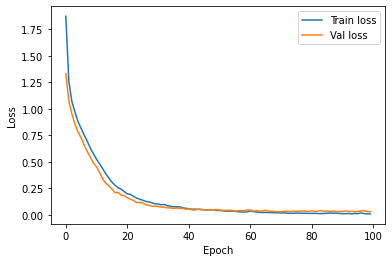

In [37]:
# Plot accuracy and loss
plt.figure()
plt.plot(train_loss_list, label='Train loss')
plt.plot(validation_loss_list, label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [42]:
model

AutoregressiveTransformer(
  (emb_i): Embeddings(
    (lut): Embedding(43, 128, padding_idx=0)
  )
  (emb_j): Embeddings(
    (lut): Embedding(43, 128, padding_idx=0)
  )
  (emb_edge_type): Embeddings(
    (lut): Embedding(10, 12, padding_idx=0)
  )
  (emb_i_size): Embeddings(
    (lut): Embedding(12, 16, padding_idx=0)
  )
  (emb_j_size): Embeddings(
    (lut): Embedding(12, 16, padding_idx=0)
  )
  (pos_emb): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (in_linear): Linear(in_features=300, out_features=256, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_

In [76]:
torch.save(model.state_dict(), "models/AutoregressiveTransformer/trained")

## Model Inference

In [43]:
def softmax_with_temperature(logits, temperature):
    probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    return probs


def weighted_sampling(probs):
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    word = np.random.choice(sorted_index, size=1, p=sorted_probs)[0]
    return word


# -- nucleus -- #
def nucleus(probs, p):
    probs /= (sum(probs) + 1e-5)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][0] + 1
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:]
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return word


def sampling(logit, p=None, t=1.0):
    logit = logit.squeeze().cpu().numpy()
    probs = softmax_with_temperature(logits=logit, temperature=t)
    
    if p is not None:
        cur_word = nucleus(probs, p=p)
    else:
        cur_word = weighted_sampling(probs)
    return cur_word

In [72]:
# TODO: Add Temperature

def predict(model, input_sequence, max_length=150):
    model.eval()
    
    SOS_token = (40, 40, 8, 10, 10)
    EOS_token = (41, 41, 9, 11, 11)
            
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        with torch.no_grad():
            # Get source mask
            tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

            y_i, y_j, y_edge_type, y_i_size, y_j_size = model(input_sequence, y_input, tgt_mask)

            # # sampling gen_cond
            # print(y_i.shape)
            # print(y_i[-1])
            curr_i = sampling(y_i[-1], t=0.2)
            cur_j = sampling(y_j[-1], t=0.2)
            cur_edge_type = sampling(y_edge_type[-1], t=0.2)
            cur_i_size = sampling(y_i_size[-1], t=0.2)
            cur_j_size = sampling(y_j_size[-1], t=0.2)

            # pred = []
            # for token in pred_tokens:
            #     next_item = token.topk(1)[1].view(-1)[-1].item() # num with highest probability
            #     pred.append(next_item)

            next_item = torch.tensor([[(curr_i, cur_j, cur_edge_type, cur_i_size, cur_j_size)]], device=device)
            # print(next_item)

            # Concatenate previous input with predicted best word
            y_input = torch.cat((y_input, next_item), dim=1)
            # print(y_input)

            # Stop if model predicts end of sentence
            # print(next_item.view(-1))
            # print(torch.tensor(EOS_token))
            if curr_i == torch.tensor(EOS_token[0]):
                break
    return y_input
    # return y_input.view(-1).tolist()

In [73]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[(40, 40, 8, 10, 10)]], dtype=torch.long, device=device),
    torch.tensor([[(40, 40, 8, 10, 10), (1, 2, 1, 2, 4), (2, 3, 2, 4, 4)]], dtype=torch.long, device=device),
    torch.tensor([[(40, 40, 8, 10, 10), (1, 2, 1, 8, 7), (2, 3, 4, 7, 8)]], dtype=torch.long, device=device),
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example}")
    print(f"Continuation: {result}")
    # print()

Example 0
Input: tensor([[[40, 40,  8, 10, 10]]], device='cuda:0')
Continuation: tensor([[[40, 40,  8, 10, 10],
         [ 1,  2,  1,  8,  4],
         [ 2,  3,  3,  8,  4],
         [ 2,  4,  3,  8,  9],
         [ 2, 14,  3,  8,  9],
         [ 3,  4,  3,  8,  4],
         [ 3, 14,  3,  8,  9],
         [ 4, 15,  3,  8,  4],
         [ 5,  6,  3,  8,  4],
         [ 6,  7,  3,  8,  4],
         [ 6, 15,  3,  8,  4],
         [ 6,  8,  3,  4,  4],
         [ 6, 14,  3,  4,  4],
         [ 6, 15,  3,  4,  4],
         [ 6,  8,  3,  4,  4],
         [ 6, 14,  3,  4,  4],
         [ 6, 15,  3,  4,  4],
         [ 7,  8,  3,  4,  4],
         [ 7, 14,  3,  4,  4],
         [ 7, 15,  3,  4,  4],
         [ 8, 16,  3,  4,  4],
         [ 9, 10,  3,  4,  4],
         [10, 15,  3,  8,  4],
         [10, 12,  3,  8,  4],
         [10, 15,  3,  8,  4],
         [ 6, 14,  3,  8,  4],
         [ 6, 15,  3,  4,  4],
         [ 6, 17,  3,  4,  4],
         [ 6, 14,  3,  4,  4],
         [ 6, 15,  3